In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Загрузка данных

In [2]:
import os, zipfile, tarfile, requests
from urllib.parse import urlsplit, urlunsplit, quote, unquote
from tqdm import tqdm

os.makedirs('data', exist_ok=True)
os.makedirs('data/images', exist_ok=True)
os.makedirs('data/masks', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('data/raw', exist_ok=True)

URLS = [
    "https://zenodo.org/record/8265464/files/Diverse Fetal Head Images-orginal-image.zip",
    "https://zenodo.org/record/8265464/files/Trans-cerebellum-orginal-size.zip",
    "https://zenodo.org/record/8265464/files/Trans-thalamic-orginal-size.zip",
    "https://zenodo.org/record/8265464/files/Trans-ventricular-orginal-size.zip",
]

def _encode_url(u):
    p = urlsplit(u)
    path = quote(p.path)
    return urlunsplit((p.scheme, p.netloc, path, p.query, p.fragment))

def _download(url, dst_path):
    headers = {'User-Agent': 'Mozilla/5.0'}
    r = requests.get(url, stream=True, headers=headers, allow_redirects=True, timeout=60)
    r.raise_for_status()
    ct = r.headers.get('content-type', '')
    if not any(x in ct for x in ('application/zip', 'octet-stream', 'application/x-zip-compressed')):
        with open('data/download_debug.html', 'wb') as f:
            f.write(r.content)
        raise RuntimeError(f"Unexpected content-type: {ct}. Saved to data/download_debug.html")
    total = int(r.headers.get('content-length', 0)) or None
    with open(dst_path, 'wb') as f, tqdm(total=total, unit='iB', unit_scale=True, desc=os.path.basename(dst_path)) as bar:
        for chunk in r.iter_content(chunk_size=1024 * 1024):
            if not chunk:
                continue
            f.write(chunk)
            if total:
                bar.update(len(chunk))

def _extract(archive_path, extract_dir):
    os.makedirs(extract_dir, exist_ok=True)
    if zipfile.is_zipfile(archive_path):
        with zipfile.ZipFile(archive_path, 'r') as z:
            z.extractall(extract_dir)
    elif tarfile.is_tarfile(archive_path):
        with tarfile.open(archive_path, 'r:*') as t:
            t.extractall(extract_dir)
    else:
        raise RuntimeError(f"Unknown archive format: {archive_path}")

def download_and_extract_all(urls):
    for u in urls:
        enc = _encode_url(u)
        fname = os.path.basename(unquote(urlsplit(enc).path))
        dst_zip = os.path.join('data', fname)
        out_dir = os.path.join('data', 'raw', os.path.splitext(fname)[0])

        if os.path.exists(dst_zip):
            print(f"[skip] already downloaded: {dst_zip}")
        else:
            print(f"[get] {u}")
            try:
                _download(enc, dst_zip)
                print(f"[ok] saved: {dst_zip}")
            except Exception as e:
                if os.path.exists(dst_zip):
                    os.remove(dst_zip)
                print(f"[fail] download error: {e}")
                continue

        if os.path.exists(out_dir) and any(os.scandir(out_dir)):
            print(f"[skip] already extracted: {out_dir}")
        else:
            try:
                print(f"[extract] -> {out_dir}")
                _extract(dst_zip, out_dir)
                print(f"[ok] extracted: {out_dir}")
            except Exception as e:
                print(f"[fail] extract error: {e}")

download_and_extract_all(URLS)

[get] https://zenodo.org/record/8265464/files/Diverse Fetal Head Images-orginal-image.zip


Diverse Fetal Head Images-orginal-image.zip: 100%|██████████| 130M/130M [00:50<00:00, 2.57MiB/s]


[ok] saved: data/Diverse Fetal Head Images-orginal-image.zip
[extract] -> data/raw/Diverse Fetal Head Images-orginal-image
[ok] extracted: data/raw/Diverse Fetal Head Images-orginal-image
[get] https://zenodo.org/record/8265464/files/Trans-cerebellum-orginal-size.zip


Trans-cerebellum-orginal-size.zip: 100%|██████████| 225M/225M [01:19<00:00, 2.83MiB/s]


[ok] saved: data/Trans-cerebellum-orginal-size.zip
[extract] -> data/raw/Trans-cerebellum-orginal-size
[ok] extracted: data/raw/Trans-cerebellum-orginal-size
[get] https://zenodo.org/record/8265464/files/Trans-thalamic-orginal-size.zip


Trans-thalamic-orginal-size.zip: 100%|██████████| 479M/479M [00:28<00:00, 16.7MiB/s]


[ok] saved: data/Trans-thalamic-orginal-size.zip
[extract] -> data/raw/Trans-thalamic-orginal-size
[ok] extracted: data/raw/Trans-thalamic-orginal-size
[get] https://zenodo.org/record/8265464/files/Trans-ventricular-orginal-size.zip


Trans-ventricular-orginal-size.zip: 100%|██████████| 185M/185M [00:11<00:00, 15.5MiB/s]


[ok] saved: data/Trans-ventricular-orginal-size.zip
[extract] -> data/raw/Trans-ventricular-orginal-size
[ok] extracted: data/raw/Trans-ventricular-orginal-size


In [3]:
%pip -q install opencv-python==4.10.0.84 numpy matplotlib tqdm scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 66.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.


In [4]:
%pip install albumentations==1.3.1 albucore==0.0.9

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.1/250.1 kB 24.7 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.24
    Uninstalling albucore-0.0.24:
      Successfully uninstalled albucore-0.0.24
  Attempting uninstall: albumentations
    Found existing installation: albumentations 2.0.8
    Uninstalling albumentations-2.0.8:
      Successfully uninstalled albumentations-2.0.8


In [5]:
import os, re, json, random, shutil, glob
from pathlib import Path
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2

SEED = 1337
random.seed(SEED); np.random.seed(SEED)

In [6]:
%pip -q install tqdm

import os, zipfile, shutil, re
from pathlib import Path
from urllib.parse import quote
import requests
from tqdm import tqdm

os.makedirs("data", exist_ok=True)
os.makedirs("data/raw", exist_ok=True)

ZENODO_BASE = "https://zenodo.org/record/8265464/files/"
ARCHIVES = [
    "Diverse Fetal Head Images.zip",
    "Trans-cerebellum.zip",
    "Trans-thalamic.zip",
    "Trans-ventricular.zip",
]

def download(url, dst):
    if Path(dst).exists():
        print(f"[skip] already downloaded: {dst}")
        return
    r = requests.get(url, stream=True, headers={"User-Agent":"Mozilla/5.0"})
    r.raise_for_status()
    total = int(r.headers.get("content-length", 0))
    with open(dst, "wb") as f, tqdm(total=total, unit="B", unit_scale=True, desc=Path(dst).name) as pbar:
        for chunk in r.iter_content(1<<20):
            if chunk: f.write(chunk); pbar.update(len(chunk))
    print(f"[ok] saved: {dst}")

def extract_zip(zip_path, out_dir):
    out_dir = Path(out_dir)
    if out_dir.exists() and any(out_dir.iterdir()):
        print(f"[skip] already extracted: {out_dir}")
        return
    out_dir.mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile(zip_path) as z:
        z.extractall(out_dir)
    print(f"[ok] extracted: {out_dir}")

for name in ARCHIVES:
    url = ZENODO_BASE + quote(name)
    dst = f"data/{name}"
    download(url, dst)
    extract_zip(dst, f"data/raw/{Path(name).stem}")


Diverse Fetal Head Images.zip: 100%|██████████| 313M/313M [01:40<00:00, 3.10MB/s]


[ok] saved: data/Diverse Fetal Head Images.zip
[ok] extracted: data/raw/Diverse Fetal Head Images


Trans-cerebellum.zip: 100%|██████████| 274M/274M [01:28<00:00, 3.11MB/s]


[ok] saved: data/Trans-cerebellum.zip
[ok] extracted: data/raw/Trans-cerebellum


Trans-thalamic.zip: 100%|██████████| 596M/596M [00:34<00:00, 17.1MB/s]


[ok] saved: data/Trans-thalamic.zip
[ok] extracted: data/raw/Trans-thalamic


Trans-ventricular.zip: 100%|██████████| 232M/232M [00:13<00:00, 16.9MB/s]


[ok] saved: data/Trans-ventricular.zip
[ok] extracted: data/raw/Trans-ventricular


In [7]:
import zipfile, fnmatch

MASK_ROOT = Path("data/masks_flat")
if MASK_ROOT.exists():
    shutil.rmtree(MASK_ROOT)
MASK_ROOT.mkdir(parents=True, exist_ok=True)

MASK_SUBZIP_PATTERNS = ["*Segmentation mask*.zip", "*segmentation*.zip", "*mask*.zip"]

def extract_matching_subzips(folder_root: Path, dataset_tag: str):
    subzips = list(folder_root.rglob("*.zip"))
    subzips = [p for p in subzips if any(fnmatch.fnmatch(p.name.lower(), pat.lower()) for pat in MASK_SUBZIP_PATTERNS)]
    if not subzips:
        print(f"[warn] no mask sub-zips found under {folder_root}")
        return 0
    count = 0
    for zpath in subzips:
        with zipfile.ZipFile(zpath) as zf:
            for m in zf.infolist():
                if m.is_dir():
                    continue
                if not m.filename.lower().endswith((".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp")):
                    continue
                base = Path(m.filename).name
                out = MASK_ROOT / f"{dataset_tag}__{base}"
                with zf.open(m) as src, open(out, "wb") as dst:
                    dst.write(src.read())
                count += 1
    return count

TOTAL_MASKS = 0
for ds in ["Diverse Fetal Head Images", "Trans-cerebellum", "Trans-thalamic", "Trans-ventricular"]:
    root = Path("data/raw") / ds
    TOTAL_MASKS += extract_matching_subzips(root, ds.replace(" ", "_"))

TOTAL_MASKS

7664

In [8]:
from pathlib import Path
import re

IMG_DIRS = [
    Path("data/raw/Diverse Fetal Head Images-orginal-image"),
    Path("data/raw/Trans-cerebellum-orginal-size"),
    Path("data/raw/Trans-thalamic-orginal-size"),
    Path("data/raw/Trans-ventricular-orginal-size"),
]
MASK_ROOT = Path("data/masks_flat")
IMG_EXTS = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")

def img_key(name: str) -> str:
    s = name.lower()
    s = re.sub(r"\.(png|jpg|jpeg|tif|tiff|bmp)$", "", s)
    s = re.sub(r"-checkpoint$", "", s)
    return s

def mask_key(name: str) -> str:
    s = name.lower()
    s = re.sub(r"\.(png|jpg|jpeg|tif|tiff|bmp)$", "", s)
    # отрезаем префикс вида "<dataset>__"
    s = re.sub(r"^[a-z0-9_ \-]+__", "", s)
    return s

# 1) изображения (без *-checkpoint)
images = []
for d in IMG_DIRS:
    if not d.exists():
        continue
    for p in d.rglob("*"):
        if p.is_file() and p.suffix.lower() in IMG_EXTS and not p.name.lower().endswith("-checkpoint.png"):
            images.append(p)

# 2) маски
masks = [p for p in MASK_ROOT.glob("*") if p.suffix.lower() in IMG_EXTS]

# 3) индексы
img_idx = {}
for p in images:
    img_idx.setdefault(img_key(p.name), []).append(p)

mask_idx = {}
for p in masks:
    mask_idx.setdefault(mask_key(p.name), []).append(p)

len(images), len(masks), len(img_idx), len(mask_idx)


(3948, 3832, 3948, 3832)

In [9]:
def pick_one(paths):
    return sorted(paths, key=lambda x: x.name)[0]

pairs = []
unmatched = []

for k, img_list in img_idx.items():
    if k in mask_idx:
        pairs.append((pick_one(img_list), pick_one(mask_idx[k])))
    else:
        unmatched.append(pick_one(img_list))

print("images:", len(images))
print("masks :", len(masks))
print("matched pairs:", len(pairs))
print("unmatched images:", len(unmatched))

print("\nSAMPLE matches:")
for i, (im, ms) in enumerate(pairs[:12], 1):
    print(f"{i:02d}. {im.name}  <->  {ms.name}")

if unmatched:
    print("\nSAMPLE unmatched image names:")
    for p in unmatched[:12]:
        print("  ", p.name)


images: 3948
masks : 3832
matched pairs: 3830
unmatched images: 118

SAMPLE matches:
01. 182_HC.png  <->  Diverse_Fetal_Head_Images__182_HC.png
02. 622_HC.png  <->  Diverse_Fetal_Head_Images__622_HC.png
03. 526_HC.png  <->  Diverse_Fetal_Head_Images__526_HC.png
04. 789_HC.png  <->  Diverse_Fetal_Head_Images__789_HC.png
05. 729_HC.png  <->  Diverse_Fetal_Head_Images__729_HC.png
06. 395_HC.png  <->  Diverse_Fetal_Head_Images__395_HC.png
07. 407_HC.png  <->  Diverse_Fetal_Head_Images__407_HC.png
08. 548_HC.png  <->  Diverse_Fetal_Head_Images__548_HC.png
09. 656_HC.png  <->  Diverse_Fetal_Head_Images__656_HC.png
10. 386_HC.png  <->  Diverse_Fetal_Head_Images__386_HC.png
11. 490_2HC.png  <->  Diverse_Fetal_Head_Images__490_2HC.png
12. 489_HC.png  <->  Diverse_Fetal_Head_Images__489_HC.png

SAMPLE unmatched image names:
   Patient00922_Plane3_1_of_1.png
   Patient01699_Plane3_2_of_2.png
   Patient00891_Plane3_3_of_3.png
   Patient01066_Plane3_1_of_2.png
   Patient01472_Plane3_2_of_4.png
   P

In [10]:
import cv2, numpy as np
from pathlib import Path

OUT = Path("data/paired_256")
(OUT/"images").mkdir(parents=True, exist_ok=True)
(OUT/"masks").mkdir(parents=True, exist_ok=True)

def read_gray(p):
    x = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
    if x is None:
        x = cv2.cvtColor(cv2.imread(str(p), cv2.IMREAD_COLOR), cv2.COLOR_BGR2GRAY)
    return x

saved = 0
for ip, mp in pairs:
    im = read_gray(ip)
    ms = cv2.imread(str(mp), cv2.IMREAD_UNCHANGED)
    if im is None or ms is None:
        continue
    if ms.ndim == 3:
        ms = cv2.cvtColor(ms, cv2.COLOR_BGR2GRAY)
    im = cv2.resize(im, (256, 256), interpolation=cv2.INTER_LINEAR)
    ms = cv2.resize(ms, (256, 256), interpolation=cv2.INTER_NEAREST).astype("uint8")
    base = f"{ip.stem}.png"  # ключ у нас совпадает по основе имени
    cv2.imwrite(str(OUT/"images"/base), im)
    cv2.imwrite(str(OUT/"masks"/base),  ms)
    saved += 1

print("saved pairs:", saved, "->", OUT)


saved pairs: 3830 -> data/paired_256


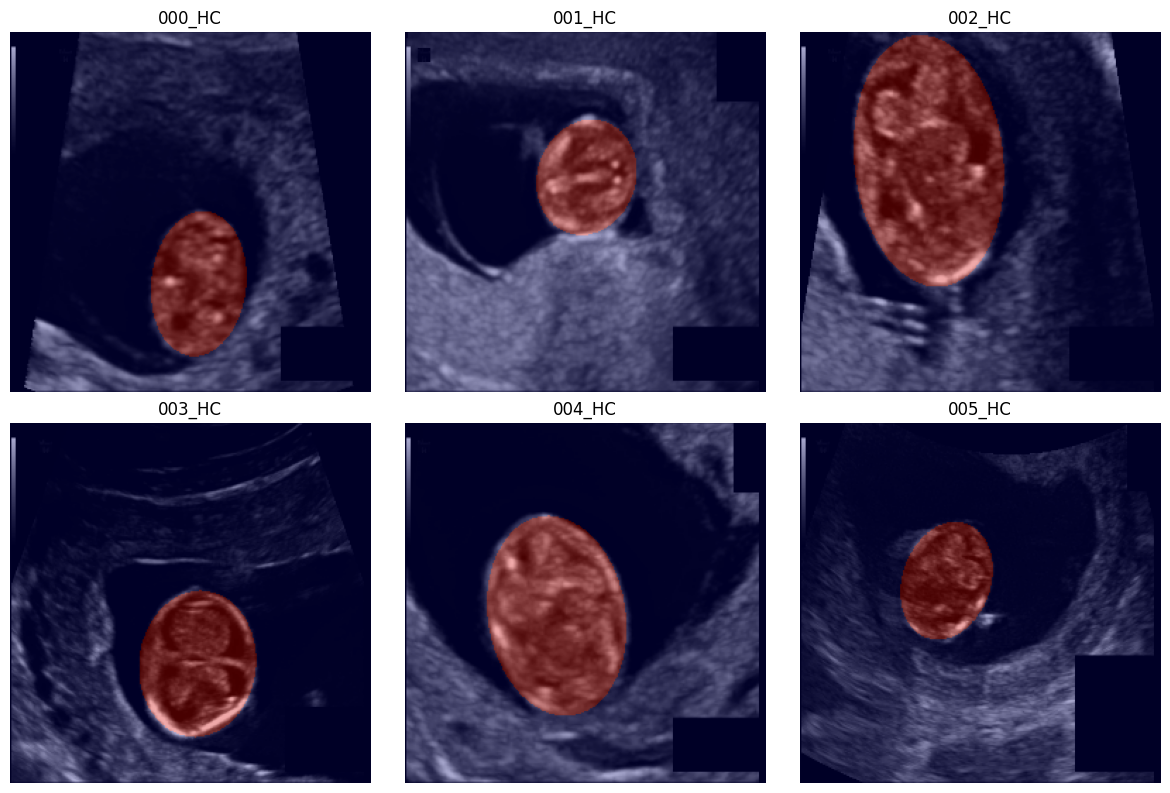

In [11]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from pathlib import Path

samples = sorted((OUT/"images").glob("*.png"))[:6]

plt.figure(figsize=(12,8))
for i, p in enumerate(samples, 1):
    m = (OUT/"masks"/p.name)
    img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
    msk = cv2.imread(str(m), cv2.IMREAD_UNCHANGED)
    overlay = cv2.applyColorMap((msk*(255//max(1, msk.max()))).astype(np.uint8), cv2.COLORMAP_JET)
    vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)*0.7 + overlay*0.3
    vis = np.clip(vis, 0, 255).astype(np.uint8)
    plt.subplot(2,3,i); plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.title(p.stem)
plt.tight_layout(); plt.show()


In [12]:
ROOT = Path("data/paired_256")
IM_DIR, MS_DIR = ROOT/"images", ROOT/"masks"
pairs = [(p, MS_DIR/p.name) for p in sorted(IM_DIR.glob("*.png")) if (MS_DIR/p.name).exists()]

paths = np.array([str(p[0]) for p in pairs])
labels = np.array([Path(p).stem.split("_")[1] if "_" in Path(p).stem else "x" for p in paths])

X_tr, X_tmp, y_tr, y_tmp = train_test_split(paths, labels, test_size=0.4, random_state=SEED, stratify=labels)
X_va, X_te, y_va, y_te = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=SEED, stratify=y_tmp)

def subset_pairs(lst):
    s = set(lst.tolist())
    return [(Path(p), MS_DIR/Path(p).name) for p in paths if p in s]

train_pairs = subset_pairs(X_tr)
val_pairs   = subset_pairs(X_va)
test_pairs  = subset_pairs(X_te)

len(train_pairs), len(val_pairs), len(test_pairs)

(2298, 766, 766)

# Аугментация

In [13]:
SIZE = 256

RZ = A.Compose([
    A.Resize(SIZE, SIZE)
])

RC_RZ = A.Compose([
    A.RandomCrop(128, 128, p=1.0),
    A.Resize(SIZE, SIZE)
])

HF = A.Compose([
    A.HorizontalFlip(p=0.3),
    A.Resize(SIZE, SIZE)
])

VF = A.Compose([
    A.VerticalFlip(p=0.3),
    A.Resize(SIZE, SIZE)
])

ROT = A.Compose([
    A.Rotate(limit=30, border_mode=cv2.BORDER_REFLECT_101, p=0.3),
    A.Resize(SIZE, SIZE)
])

CMB = A.Compose([
    A.RandomCrop(128, 128, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, border_mode=cv2.BORDER_REFLECT_101, p=0.5),
    A.Resize(SIZE, SIZE)
])

RRC_RZ = A.Compose([
    A.RandomResizedCrop(height=SIZE, width=SIZE, scale=(0.6, 0.8), ratio=(1.0, 1.0), p=1.0),
    A.Resize(SIZE, SIZE)
])

PAD_RC_RZ = A.Compose([
    A.PadIfNeeded(min_height=SIZE+32, min_width=SIZE+32, border_mode=cv2.BORDER_REFLECT_101, p=1.0),
    A.RandomCrop(SIZE, SIZE, p=1.0),
    A.Resize(SIZE, SIZE)
])

ADV = A.Compose([
    A.RandomBrightnessContrast(p=0.5),
    A.ElasticTransform(
        alpha=1.0,
        sigma=50.0,
        alpha_affine=0.0,                       # <-- раньше было 0.0, теперь нужно None
        interpolation=cv2.INTER_LINEAR,
        border_mode=cv2.BORDER_REFLECT_101,
        p=0.5
    ),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.5),
    A.Resize(SIZE, SIZE, interpolation=cv2.INTER_LINEAR),
])

PIPELINES = {
    "RZ": RZ,
    "RC_RZ": RC_RZ,
    "HF": HF,
    "VF": VF,
    "ROT": ROT,
    "CMB": CMB,
    "RRC_RZ": RRC_RZ,
    "PAD_RC_RZ": PAD_RC_RZ,
    "ADV": ADV,
}

In [14]:
OUT = Path("data/aug")
if OUT.exists(): shutil.rmtree(OUT)
for sub in ["train/images","train/masks","val/images","val/masks","test/images","test/masks"]:
    (OUT/sub).mkdir(parents=True, exist_ok=True)

COPIES = {
    "RZ": 1,
    "RC_RZ": 1,
    "HF": 1,
    "VF": 1,
    "ROT": 1,
    "CMB": 1,
    "RRC_RZ": 1,
    "PAD_RC_RZ": 1,
    "ADV": 2,
}

def read_gray(p):
    x = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
    if x is None:
        x = cv2.cvtColor(cv2.imread(str(p), cv2.IMREAD_COLOR), cv2.COLOR_BGR2GRAY)
    return x

def apply_aug(aug, img, msk):
    msk = msk.astype(np.uint8)
    return aug(image=img, mask=msk)

count = 0
for ip, mp in tqdm(train_pairs, desc="augment train"):
    img = read_gray(ip)
    msk = cv2.imread(str(mp), cv2.IMREAD_UNCHANGED)
    if msk is None:
        continue
    if msk.ndim == 3:
        msk = cv2.cvtColor(msk, cv2.COLOR_BGR2GRAY)
    for name, aug in PIPELINES.items():
        for k in range(COPIES[name]):
            t = apply_aug(aug, img, msk)
            base = f"{ip.stem}__{name}_{k:02d}.png"
            cv2.imwrite(str(OUT/"train/images"/base), t["image"])
            cv2.imwrite(str(OUT/"train/masks"/base),  t["mask"])
            count += 1

for subset, pairs_ in [("val", val_pairs), ("test", test_pairs)]:
    for ip, mp in tqdm(pairs_, desc=f"prep {subset}"):
        img = read_gray(ip)
        msk = cv2.imread(str(mp), cv2.IMREAD_UNCHANGED)
        if msk is None:
            continue
        if msk.ndim == 3:
            msk = cv2.cvtColor(msk, cv2.COLOR_BGR2GRAY)
        t = RZ(image=img, mask=msk)
        base = f"{ip.stem}.png"
        cv2.imwrite(str(OUT/f"{subset}/images"/base), t["image"])
        cv2.imwrite(str(OUT/f"{subset}/masks"/base),  t["mask"])

print("train augmented samples:", count)

prep test: 100%|██████████| 766/766 [00:02<00:00, 355.20it/s]

train augmented samples: 22980


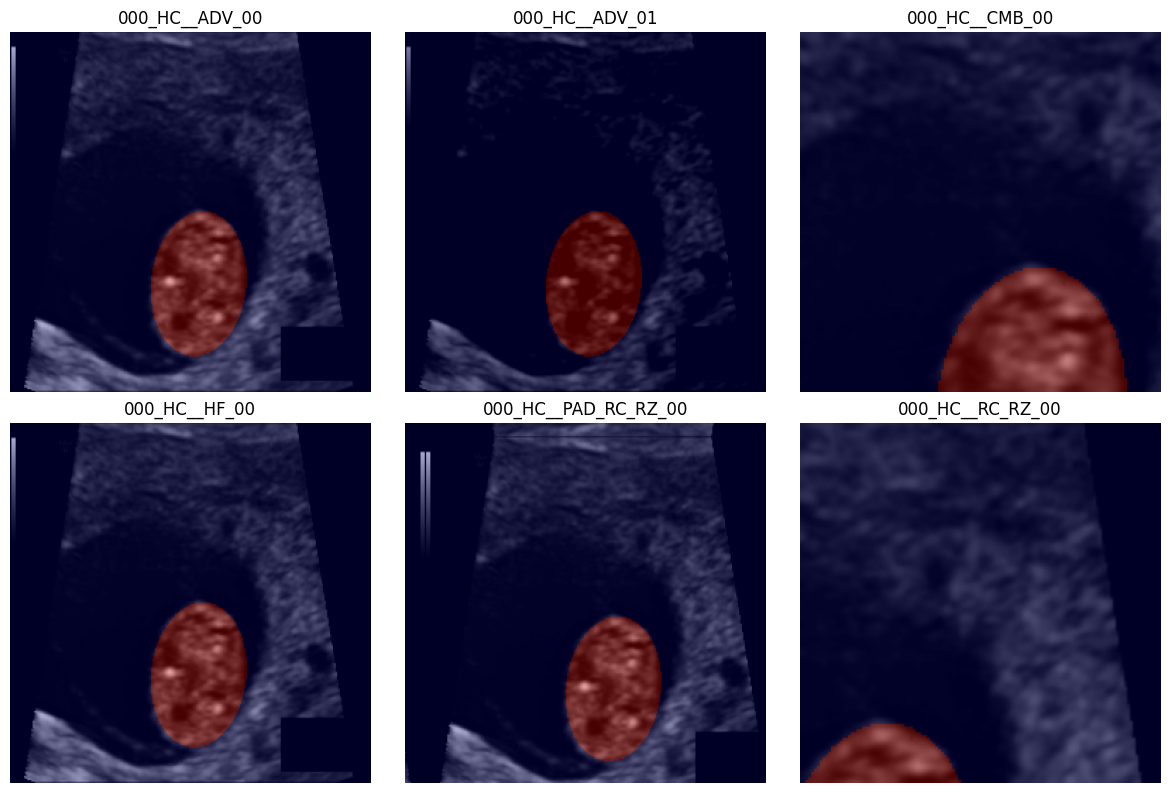

In [15]:
import matplotlib.pyplot as plt

samples = sorted((OUT/"train/images").glob("*.png"))[:6]
plt.figure(figsize=(12,8))
for i, p in enumerate(samples, 1):
    m = (OUT/"train/masks"/p.name)
    img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
    msk = cv2.imread(str(m), cv2.IMREAD_UNCHANGED)
    ov = cv2.applyColorMap((msk*(255//max(1, msk.max()))).astype(np.uint8), cv2.COLORMAP_JET)
    vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)*0.7 + ov*0.3
    vis = np.clip(vis, 0, 255).astype(np.uint8)
    plt.subplot(2,3,i); plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.title(p.stem)
plt.tight_layout(); plt.show()


In [16]:
def count_pairs(folder):
    ims = len(list((folder/"images").glob("*.png")))
    ms  = len(list((folder/"masks").glob("*.png")))
    return {"images": ims, "masks": ms}

stats = {
    "train": count_pairs(OUT/"train"),
    "val":   count_pairs(OUT/"val"),
    "test":  count_pairs(OUT/"test"),
    "seed":  SEED,
    "pipelines": list(PIPELINES.keys()),
    "copies": COPIES,
}
with open(OUT/"manifest.json","w") as f:
    json.dump(stats, f, indent=2)
stats

{'train': {'images': 22980, 'masks': 22980},
 'val': {'images': 766, 'masks': 766},
 'test': {'images': 766, 'masks': 766},
 'seed': 1337,
 'pipelines': ['RZ',
  'RC_RZ',
  'HF',
  'VF',
  'ROT',
  'CMB',
  'RRC_RZ',
  'PAD_RC_RZ',
  'ADV'],
 'copies': {'RZ': 1,
  'RC_RZ': 1,
  'HF': 1,
  'VF': 1,
  'ROT': 1,
  'CMB': 1,
  'RRC_RZ': 1,
  'PAD_RC_RZ': 1,
  'ADV': 2}}

In [17]:
from collections import Counter

In [18]:
MSK_DIR = Path("data/paired_256/masks")
counts = Counter()
for p in MSK_DIR.glob("*.png"):
    m = cv2.imread(str(p), cv2.IMREAD_UNCHANGED)
    if m is None: continue
    if m.ndim == 3: m = cv2.cvtColor(m, cv2.COLOR_BGR2GRAY)
    vals, cnt = np.unique(m, return_counts=True)
    for v,c in zip(vals, cnt): counts[int(v)] += int(c)
sorted(counts.items())[:20], (min(counts), max(counts))

([(0, 167983001), (38, 77227828), (75, 5403357), (113, 388694)], (0, 113))

EXTRACTING BOUNDING BOXES FROM AUGMENTED DATASET

=== Processing TRAIN ===
Found 22980 image pairs


Processing train: 100%|██████████| 22980/22980 [00:38<00:00, 590.09it/s]



train statistics:
  Total images: 22980
  Brain : 21807 boxes in 21654 images (94.2%)
  CSP   : 13190 boxes in 13127 images (57.1%)
  LV    :  5845 boxes in  5822 images (25.3%)
  Images with all 3 classes: 4855

=== Processing VAL ===
Found 766 image pairs


Processing val: 100%|██████████| 766/766 [00:01<00:00, 641.88it/s]



val statistics:
  Total images: 766
  Brain :   717 boxes in   717 images (93.6%)
  CSP   :   452 boxes in   452 images (59.0%)
  LV    :   219 boxes in   219 images (28.6%)
  Images with all 3 classes: 186

=== Processing TEST ===
Found 766 image pairs


Processing test: 100%|██████████| 766/766 [00:01<00:00, 643.51it/s]



test statistics:
  Total images: 766
  Brain :   721 boxes in   721 images (94.1%)
  CSP   :   462 boxes in   462 images (60.3%)
  LV    :   210 boxes in   210 images (27.4%)
  Images with all 3 classes: 178

OVERALL DATASET STATISTICS

Total images: 24512
  Train: 22980
  Val:   766
  Test:  766

Boxes by class:
  Brain :  23245 boxes in  23092 images
  CSP   :  14104 boxes in  14041 images
  LV    :   6274 boxes in   6251 images

VISUALIZING EXAMPLES

Visualizing 12 examples with all 3 classes from train...


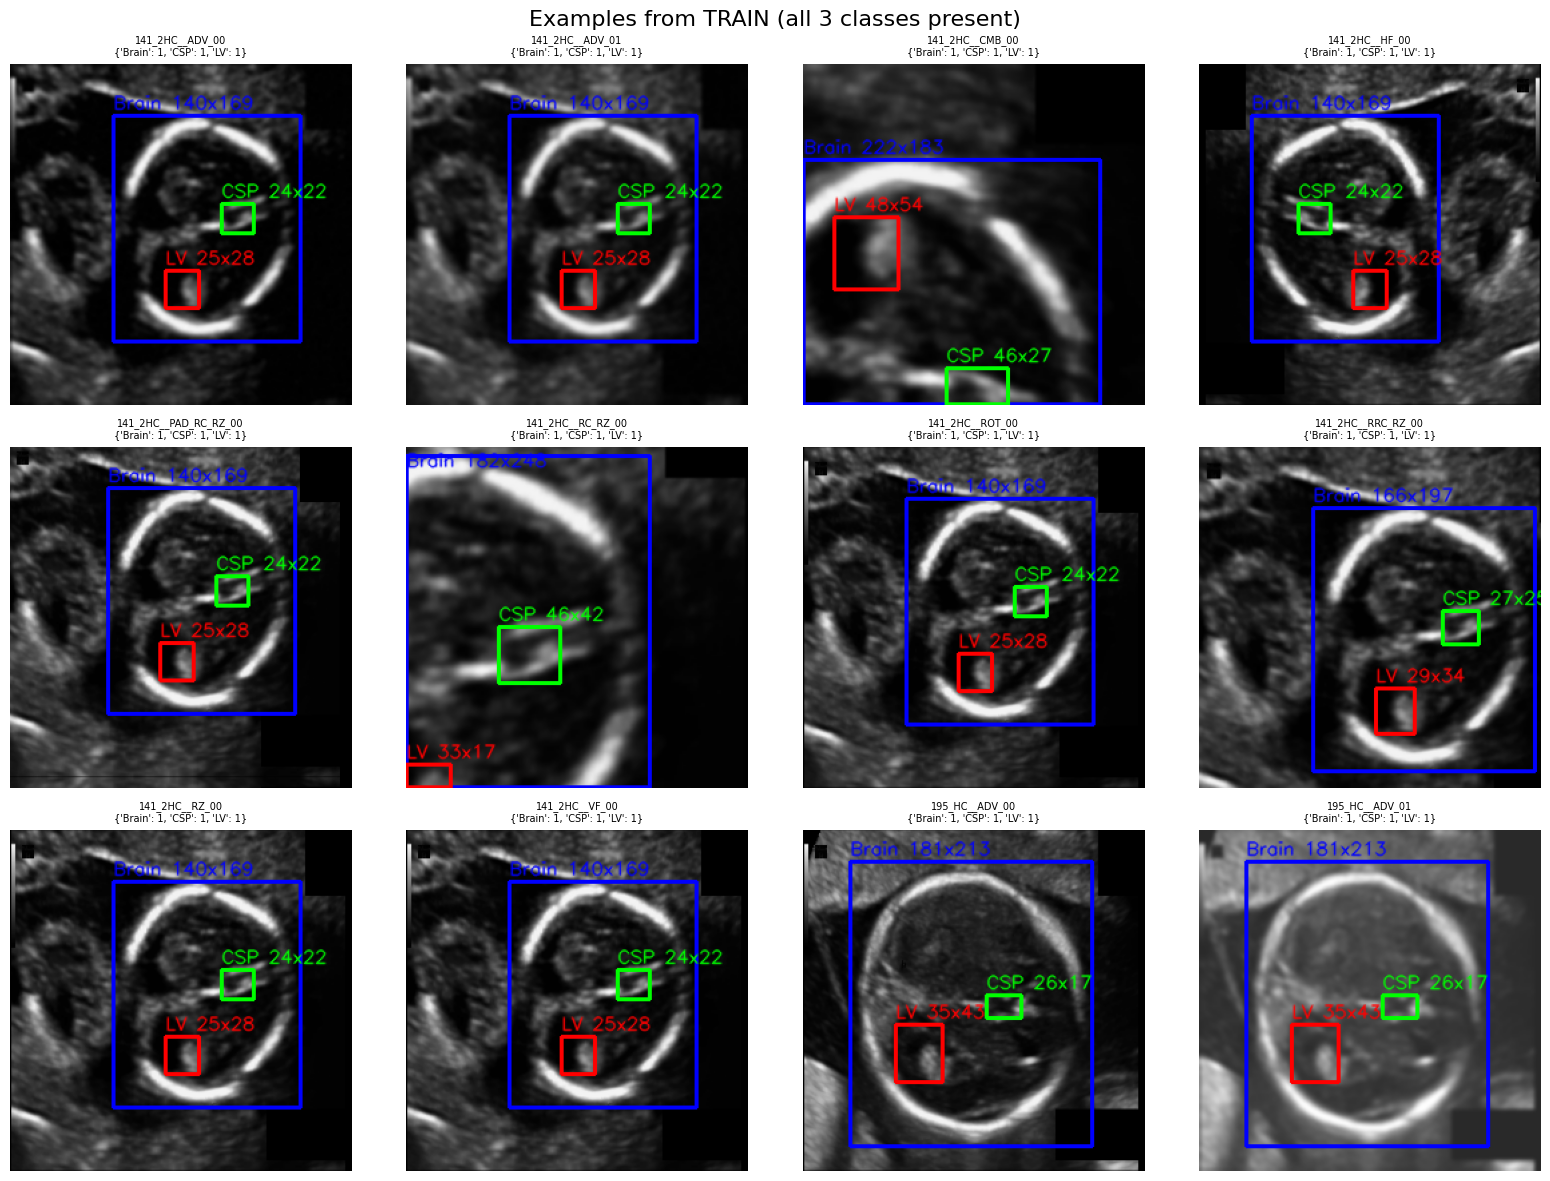

Saved: data/aug_viz/overview_train_all3classes.png

Visualizing 12 examples with all 3 classes from val...


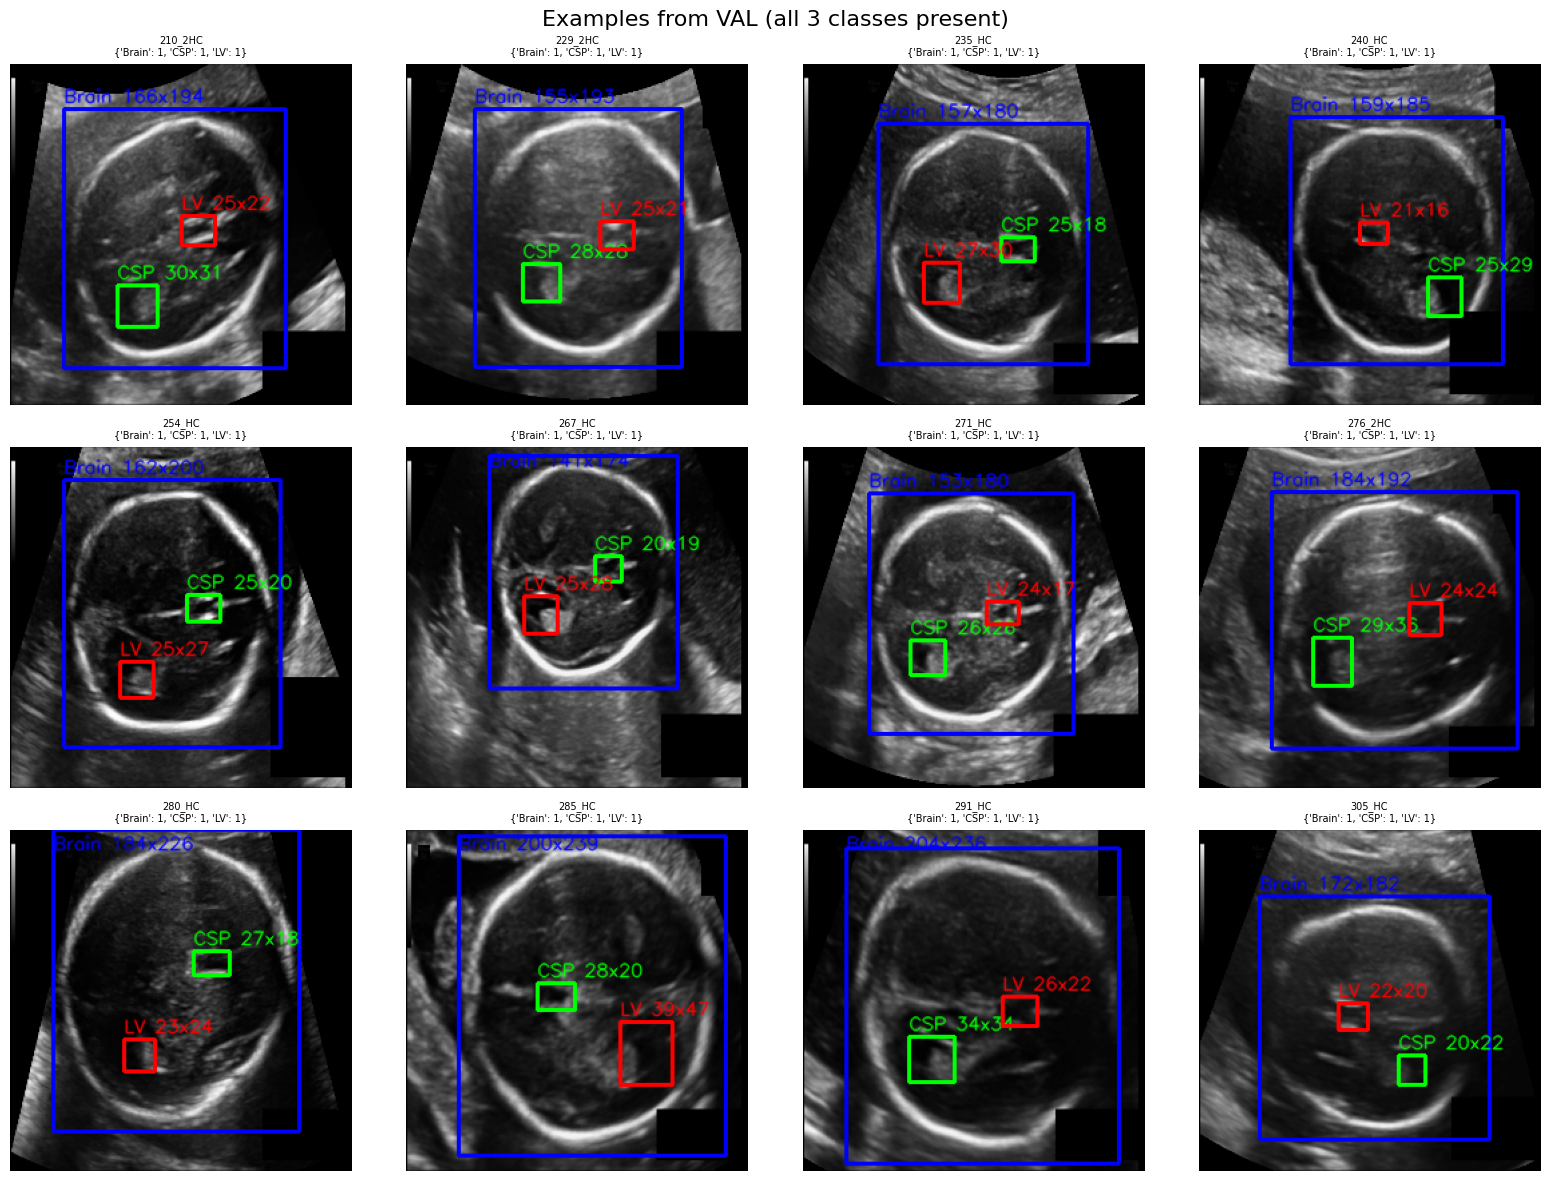

Saved: data/aug_viz/overview_val_all3classes.png

Visualizing 12 examples with all 3 classes from test...


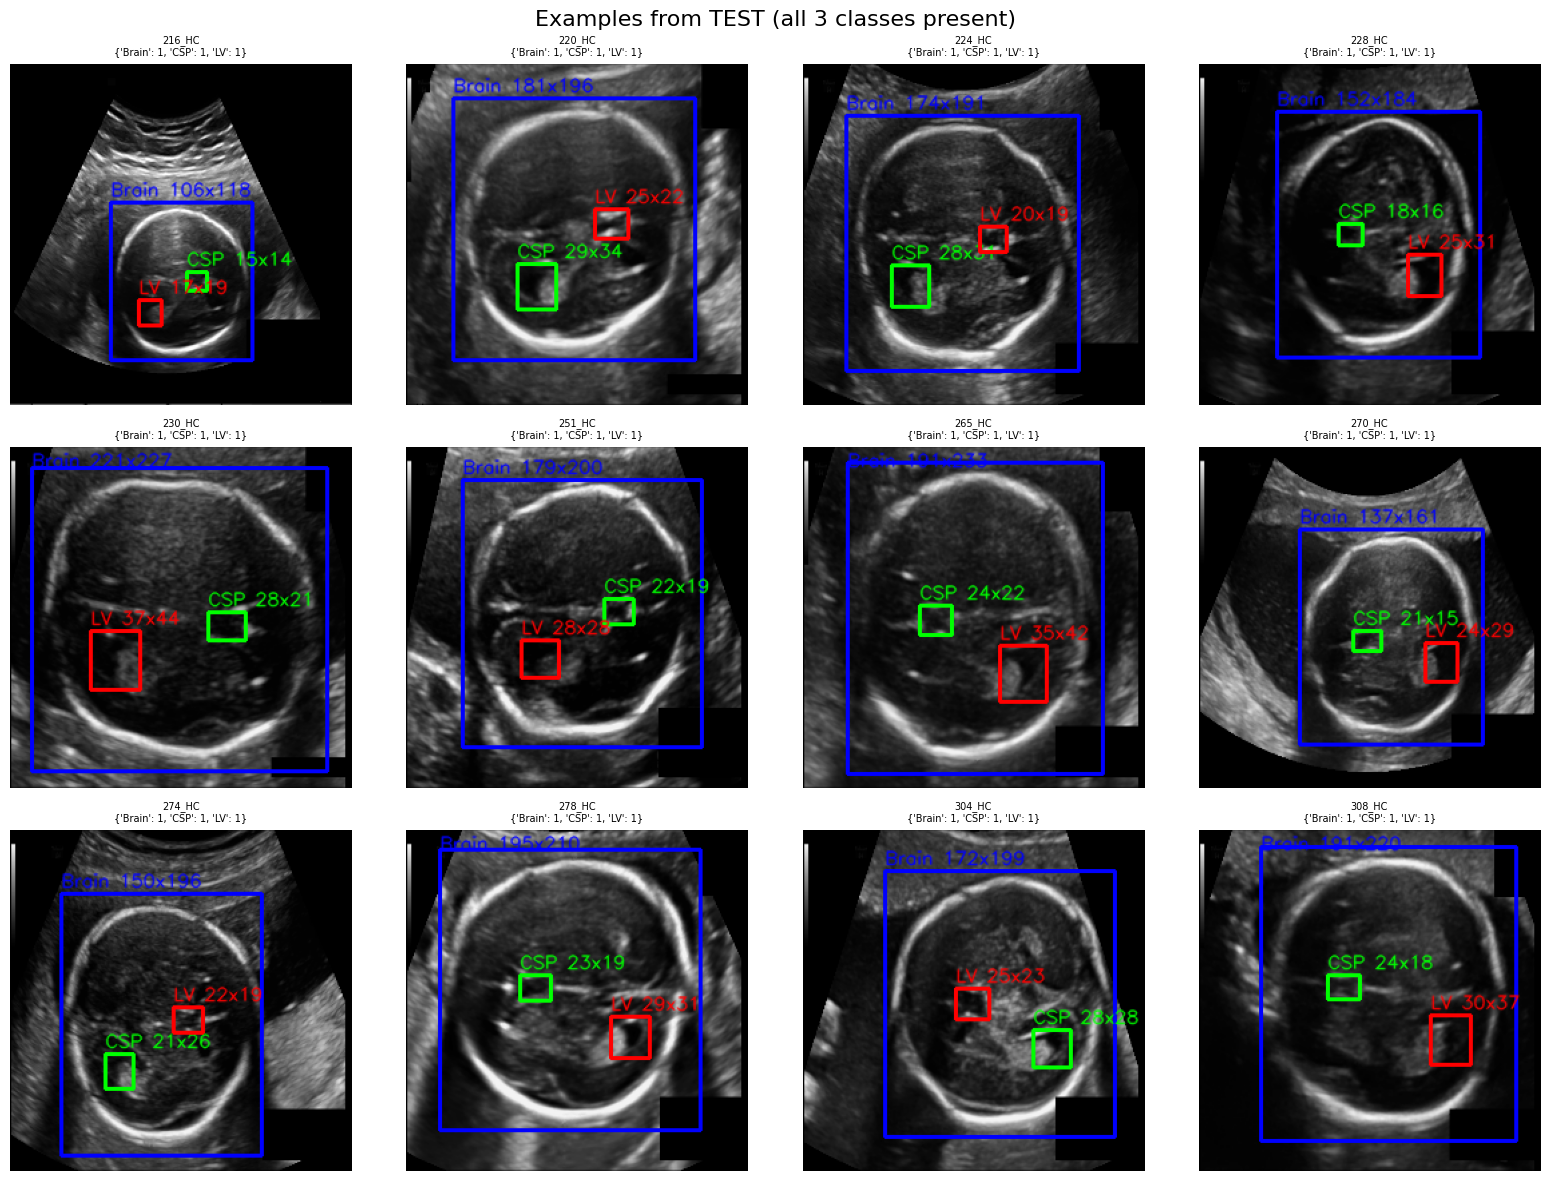

Saved: data/aug_viz/overview_test_all3classes.png

✓ DONE!

Bounding box files saved to: data/aug_bboxes
Visualizations saved to: data/aug_viz

Output data structure:
  data/aug_bboxes/train/*.txt
  data/aug_bboxes/val/*.txt
  data/aug_bboxes/test/*.txt


In [19]:
import os, csv, shutil
from pathlib import Path
import numpy as np, cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Optional

ROOT = Path("data/aug")
TRAIN_IMG = ROOT / "train/images"
TRAIN_MSK = ROOT / "train/masks"
VAL_IMG = ROOT / "val/images"
VAL_MSK = ROOT / "val/masks"
TEST_IMG = ROOT / "test/images"
TEST_MSK = ROOT / "test/masks"

OUT_ROOT = Path("data/aug_bboxes")
VIZ_ROOT = Path("data/aug_viz")

for split in ["train", "val", "test"]:
    (OUT_ROOT / split).mkdir(parents=True, exist_ok=True)
    (VIZ_ROOT / split).mkdir(parents=True, exist_ok=True)

MIN_AREA_MAP = {
    "Brain": 500,
    "CSP": 10,
    "LV": 10
}
DILATE_ITERS = 1
PAD_RATIO = 0.05
USE_ROTATED = False

CLASSES = {
    "Brain": 0,
    "CSP": 1,
    "LV": 2
}

CLASS_ID_TO_NAME = {
    38: "Brain",
    75: "CSP",
    113: "LV"
}

from dataclasses import dataclass
from typing import List, Tuple, Dict

@dataclass
class Box:
    cls: str
    cx: float; cy: float
    w: float;  h: float
    angle: float = 0.0
    aabb: Tuple[int,int,int,int] = (0,0,0,0)

def _clamp(x, lo, hi):
    return max(lo, min(hi, x))

def _pad_aabb(x1,y1,x2,y2, pad, W, H):
    pw = int(round(pad * (x2-x1)))
    ph = int(round(pad * (y2-y1)))
    x1 = _clamp(x1 - pw, 0, W-1)
    y1 = _clamp(y1 - ph, 0, H-1)
    x2 = _clamp(x2 + pw, 0, W-1)
    y2 = _clamp(y2 + ph, 0, H-1)
    return x1,y1,x2,y2

def mask_to_boxes(mask: np.ndarray,
                  classes: Dict[int,str],
                  min_area_map: Dict[str, int],
                  dilate_iters=0,
                  pad_ratio=0.0,
                  use_rotated=False) -> List[Box]:
    H, W = mask.shape[:2]
    boxes: List[Box] = []
    kernel = np.ones((3,3), np.uint8) if dilate_iters > 0 else None

    for cid, cname in classes.items():
        min_area_px = min_area_map.get(cname, 64)

        m = (mask == cid).astype(np.uint8) * 255
        if dilate_iters > 0:
            m = cv2.dilate(m, kernel, iterations=dilate_iters)
        cnts, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for c in cnts:
            area = cv2.contourArea(c)
            if area < min_area_px:
                continue

            if use_rotated:
                rect = cv2.minAreaRect(c)
                (cx, cy), (w, h), ang = rect
                if w < h:
                    w, h = h, w
                    ang = (ang + 90.0) % 180.0
                box_pts = cv2.boxPoints(((cx,cy),(w,h),ang)).astype(int)
                x1,y1 = box_pts[:,0].min(), box_pts[:,1].min()
                x2,y2 = box_pts[:,0].max(), box_pts[:,1].max()
                x1,y1,x2,y2 = _pad_aabb(x1,y1,x2,y2, pad_ratio, W, H)
                boxes.append(Box(cname, float(cx), float(cy), float(w), float(h), float(ang), (x1,y1,x2,y2)))
            else:
                x,y,w,h = cv2.boundingRect(c)
                x1,y1,x2,y2 = _pad_aabb(x, y, x+w, y+h, pad_ratio, W, H)
                cx = (x1 + x2) / 2.0
                cy = (y1 + y2) / 2.0
                boxes.append(Box(cname, cx, cy, x2-x1, y2-y1, 0.0, (x1,y1,x2,y2)))

    return boxes

def write_bbox_txt(txt_path: Path, boxes: List[Box], img_w: int, img_h: int, cls_map: Dict[str,int]):
    with open(txt_path, "w") as f:
        for b in boxes:
            if b.cls not in cls_map:
                continue
            cxn = b.cx / img_w
            cyn = b.cy / img_h
            wn  = b.w  / img_w
            hn  = b.h  / img_h
            f.write(f"{cls_map[b.cls]} {cxn:.6f} {cyn:.6f} {wn:.6f} {hn:.6f}\n")

def draw_boxes_bgr(img_bgr: np.ndarray, boxes: List[Box]) -> np.ndarray:
    out = img_bgr.copy()
    class_colors = {
        "Brain": (255, 0, 0),
        "CSP": (0, 255, 0),
        "LV": (0, 0, 255)
    }

    for b in boxes:
        color = class_colors.get(b.cls, (255, 255, 0))
        x1,y1,x2,y2 = b.aabb
        cv2.rectangle(out, (x1,y1), (x2,y2), color, 2)
        cv2.putText(out, f"{b.cls} {int(b.w)}x{int(b.h)}", (x1, max(15, y1-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 1, cv2.LINE_AA)
    return out

def process_split(split_name, img_dir, msk_dir, out_dir, viz_dir):
    print(f"\n=== Processing {split_name.upper()} ===")

    img_files = sorted(img_dir.glob("*.png"))
    msk_files = sorted(msk_dir.glob("*.png"))

    pairs = []
    for img_path in img_files:
        msk_path = msk_dir / img_path.name
        if msk_path.exists():
            pairs.append((img_path, msk_path))

    print(f"Found {len(pairs)} image pairs")

    stats = {"Brain": 0, "CSP": 0, "LV": 0}
    images_with_class = {"Brain": 0, "CSP": 0, "LV": 0}
    pairs_with_all_classes = []

    for ip, mp in tqdm(pairs, desc=f"Processing {split_name}"):
        img = cv2.imread(str(ip), cv2.IMREAD_GRAYSCALE)
        msk = cv2.imread(str(mp), cv2.IMREAD_UNCHANGED)

        if img is None or msk is None:
            continue

        if msk.ndim == 3:
            msk = cv2.cvtColor(msk, cv2.COLOR_BGR2GRAY)

        H, W = img.shape[:2]

        boxes = mask_to_boxes(msk, CLASS_ID_TO_NAME, MIN_AREA_MAP,
                             DILATE_ITERS, PAD_RATIO, USE_ROTATED)

        txt_path = out_dir / f"{ip.stem}.txt"
        write_bbox_txt(txt_path, boxes, W, H, CLASSES)

        img_classes = set()
        for b in boxes:
            stats[b.cls] += 1
            img_classes.add(b.cls)

        for cls in img_classes:
            images_with_class[cls] += 1

        if len(img_classes) == 3:
            pairs_with_all_classes.append((ip, mp))

    print(f"\n{split_name} statistics:")
    print(f"  Total images: {len(pairs)}")
    for cls in ["Brain", "CSP", "LV"]:
        pct = (images_with_class[cls] / len(pairs) * 100) if len(pairs) > 0 else 0
        print(f"  {cls:6s}: {stats[cls]:5d} boxes in {images_with_class[cls]:5d} images ({pct:.1f}%)")
    print(f"  Images with all 3 classes: {len(pairs_with_all_classes)}")

    return pairs, pairs_with_all_classes, stats, images_with_class

print("=" * 60)
print("EXTRACTING BOUNDING BOXES FROM AUGMENTED DATASET")
print("=" * 60)

train_pairs, train_all3, train_stats, train_img_stats = process_split(
    "train", TRAIN_IMG, TRAIN_MSK, OUT_ROOT/"train", VIZ_ROOT/"train"
)

val_pairs, val_all3, val_stats, val_img_stats = process_split(
    "val", VAL_IMG, VAL_MSK, OUT_ROOT/"val", VIZ_ROOT/"val"
)

test_pairs, test_all3, test_stats, test_img_stats = process_split(
    "test", TEST_IMG, TEST_MSK, OUT_ROOT/"test", VIZ_ROOT/"test"
)

print("\n" + "=" * 60)
print("OVERALL DATASET STATISTICS")
print("=" * 60)

total_images = len(train_pairs) + len(val_pairs) + len(test_pairs)
print(f"\nTotal images: {total_images}")
print(f"  Train: {len(train_pairs)}")
print(f"  Val:   {len(val_pairs)}")
print(f"  Test:  {len(test_pairs)}")

print("\nBoxes by class:")
for cls in ["Brain", "CSP", "LV"]:
    total_boxes = train_stats[cls] + val_stats[cls] + test_stats[cls]
    total_imgs = train_img_stats[cls] + val_img_stats[cls] + test_img_stats[cls]
    print(f"  {cls:6s}: {total_boxes:6d} boxes in {total_imgs:6d} images")

print("\n" + "=" * 60)
print("VISUALIZING EXAMPLES")
print("=" * 60)

def visualize_samples_with_all_classes(pairs_all3, split_name, num_samples=12):
    print(f"\nVisualizing {num_samples} examples with all 3 classes from {split_name}...")

    if len(pairs_all3) == 0:
        print(f"No images with all 3 classes found in {split_name}")
        return

    samples = pairs_all3[:num_samples]
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    fig.suptitle(f'Examples from {split_name.upper()} (all 3 classes present)', fontsize=16)

    for idx, (ip, mp) in enumerate(samples):
        if idx >= num_samples:
            break

        img = cv2.imread(str(ip), cv2.IMREAD_GRAYSCALE)
        msk = cv2.imread(str(mp), cv2.IMREAD_UNCHANGED)

        if img is None or msk is None:
            continue

        if msk.ndim == 3:
            msk = cv2.cvtColor(msk, cv2.COLOR_BGR2GRAY)

        boxes = mask_to_boxes(msk, CLASS_ID_TO_NAME, MIN_AREA_MAP,
                             DILATE_ITERS, PAD_RATIO, USE_ROTATED)
        vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        vis = draw_boxes_bgr(vis, boxes)

        class_counts = {}
        for b in boxes:
            class_counts[b.cls] = class_counts.get(b.cls, 0) + 1

        row, col = idx // 4, idx % 4
        axes[row, col].imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
        axes[row, col].set_title(f"{ip.stem[:30]}\n{class_counts}", fontsize=7)
        axes[row, col].axis('off')

    for idx in range(len(samples), 12):
        row, col = idx // 4, idx % 4
        axes[row, col].axis('off')

    plt.tight_layout()
    out_path = VIZ_ROOT / f"overview_{split_name}_all3classes.png"
    plt.savefig(str(out_path), dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {out_path}")

visualize_samples_with_all_classes(train_all3, "train", 12)
visualize_samples_with_all_classes(val_all3, "val", 12)
visualize_samples_with_all_classes(test_all3, "test", 12)

print("\n" + "=" * 60)
print("✓ DONE!")
print("=" * 60)
print(f"\nBounding box files saved to: {OUT_ROOT}")
print(f"Visualizations saved to: {VIZ_ROOT}")
print("\nOutput data structure:")
print(f"  {OUT_ROOT}/train/*.txt")
print(f"  {OUT_ROOT}/val/*.txt")
print(f"  {OUT_ROOT}/test/*.txt")

In [21]:
from pathlib import Path
import numpy as np, cv2, json

TRAIN_MASK_DIRS = [
    Path("data/aug/train/masks"),
    Path("data/paired_256/masks"),
]
mask_dir = next((p for p in TRAIN_MASK_DIRS if p.exists()), None)

VALUE_TO_ID = {0:0, 38:1, 75:2, 113:3}
NCLASSES = 4

def remap_mask_to_ids(mask):
    out = np.zeros_like(mask, dtype=np.uint8)
    for v,i in VALUE_TO_ID.items():
        out[mask==v] = i
    return out


In [22]:
from collections import Counter

class_counts = np.zeros(NCLASSES, dtype=np.int64)

mask_paths = sorted(mask_dir.glob("*.png"))
for p in mask_paths:
    m = cv2.imread(str(p), cv2.IMREAD_UNCHANGED)
    if m is None:
        continue
    if m.ndim == 3:
        m = cv2.cvtColor(m, cv2.COLOR_BGR2GRAY)
    m = remap_mask_to_ids(m)
    uniq, cnt = np.unique(m, return_counts=True)
    class_counts[uniq] += cnt

class_counts[class_counts == 0] = 1
class_counts


array([901800669, 563442323,  37671633,   3102655])

In [23]:
min_w, max_w = 0.1, 0.9

total = class_counts.sum()
raw = total / class_counts.astype(np.float64)
raw = raw / raw.sum()

mn, mx = raw.min(), raw.max()
if mx > mn:
    weights = (raw - mn) / (mx - mn) * (max_w - min_w) + min_w
else:
    weights = np.full_like(raw, (min_w + max_w)/2.0)

weights_list = weights.tolist()
weights_list


[0.1, 0.10165858265480174, 0.16335397132190693, 0.9]

In [24]:
out = {
    "class_counts": class_counts.tolist(),
    "weights": weights_list,
    "value_to_id": VALUE_TO_ID,
    "range": [min_w, max_w],
}
Path("data/weights").mkdir(parents=True, exist_ok=True)
with open("data/weights/class_weights.json","w") as f:
    json.dump(out, f, indent=2)

try:
    import torch
    torch_weights = torch.tensor(weights_list, dtype=torch.float32)
    torch_weights
except Exception as e:
    print("torch недоступен:", e)


In [ ]:
%pip -q uninstall -y torch torchvision torchaudio
%pip -q install torch torchvision --index-url https://download.pytorch.org/whl/cu121

In [25]:
import torch
print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("device name:", torch.cuda.get_device_name(0))

torch: 2.8.0+cu126
cuda available: True
device count: 1
device name: Tesla T4


In [ ]:
%pip -q uninstall -y albumentations albucore
%pip -q install --no-cache-dir "albumentations==1.4.14" "albucore>=0.0.13,<0.1" opencv-python


Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Training

In [28]:
%pip install segment-anything
%pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 15.9 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from PIL import Image
import os
from tqdm import tqdm
from torch.amp import autocast, GradScaler
import json
from pathlib import Path


def check_data_structure():
    """Проверяем структуру данных"""
    print("🔍 ПРОВЕРКА СТРУКТУРЫ ДАННЫХ:")

    paths_to_check = [
        'data/aug/train/images',
        'data/aug/train/masks',
        'data/aug/val/images',
        'data/aug/val/masks',
        'data/aug_bboxes/train',
        'data/aug_bboxes/val'
    ]

    for path in paths_to_check:
        exists = os.path.exists(path)
        file_count = len(list(Path(path).glob('*'))) if exists else 0
        print(f"   {path}: {'✅' if exists else '❌'} ({file_count} файлов)")


    print("\n📁 ПРОВЕРКА ФАЙЛОВ:")

    train_images = list(Path('data/aug/train/images').glob('*'))
    if train_images:
        print(f"   Train images: {len(train_images)} файлов")
        print(f"   Пример: {train_images[0].name}")


    train_masks = list(Path('data/aug/train/masks').glob('*'))
    if train_masks:
        print(f"   Train masks: {len(train_masks)} файлов")
        print(f"   Пример: {train_masks[0].name}")

    train_bboxes = list(Path('data/aug_bboxes/train').glob('*.txt'))
    if train_bboxes:
        print(f"   Train bboxes: {len(train_bboxes)} файлов")
        print(f"   Пример: {train_bboxes[0].name}")

        if train_bboxes:
            with open(train_bboxes[0], 'r') as f:
                content = f.read().strip()
                print(f"   Содержимое: {content[:100]}...")


check_data_structure()



class FetSAMDataset(Dataset):
    """Dataset for FetSAM training with corrected paths and YOLO bbox support"""

    def __init__(self, image_dir, mask_dir, bbox_dir=None, transform=None, use_bboxes=True, image_size=256):
        self.image_dir = Path(image_dir)
        self.mask_dir = Path(mask_dir)
        self.bbox_dir = Path(bbox_dir) if bbox_dir else None
        self.transform = transform
        self.use_bboxes = use_bboxes
        self.image_size = image_size

        self.samples = self._get_valid_samples()
        print(f"✅ Found {len(self.samples)} valid image-mask pairs")

        if len(self.samples) == 0:
            print("❌ No samples found! Please check your data paths.")
            print(f"   Image dir: {self.image_dir}")
            print(f"   Mask dir: {self.mask_dir}")
            if self.use_bboxes:
                print(f"   Bbox dir: {self.bbox_dir}")

    def _get_valid_samples(self):
        """Get list of valid image-mask-bbox triplets"""
        samples = []

        if not self.image_dir.exists() or not self.mask_dir.exists():
            print(f"❌ Missing directories:")
            print(f"   Images: {self.image_dir.exists()}")
            print(f"   Masks: {self.mask_dir.exists()}")
            return samples


        image_files = list(self.image_dir.glob('*.png')) + list(self.image_dir.glob('*.jpg'))
        print(f"   Found {len(image_files)} image files")

        for img_path in image_files:
            base_name = img_path.stem


            mask_path = self.mask_dir / f"{base_name}.png"
            if not mask_path.exists():
                continue


            if self.use_bboxes and self.bbox_dir:
                bbox_path = self.bbox_dir / f"{base_name}.txt"
                if not bbox_path.exists():
                    continue

            samples.append({
                'image_path': img_path,
                'mask_path': mask_path,
                'base_name': base_name
            })

        return samples

    def _load_bbox_yolo(self, base_name):
        """Load bounding box from YOLO format TXT file"""
        if not self.bbox_dir:
            return None

        bbox_path = self.bbox_dir / f"{base_name}.txt"

        if not bbox_path.exists():
            return None

        try:
            with open(bbox_path, 'r') as f:
                lines = f.readlines()


            bboxes = []
            for line in lines:
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id, cx, cy, w, h = map(float, parts)


                    x_center = cx * self.image_size
                    y_center = cy * self.image_size
                    width = w * self.image_size
                    height = h * self.image_size


                    x = x_center - width / 2
                    y = y_center - height / 2

                    bboxes.append([x, y, width, height])


            return torch.tensor(bboxes[0], dtype=torch.float32) if bboxes else None

        except Exception as e:
            print(f"⚠️ Error loading bbox for {base_name}: {e}")
            return None

    def _compute_bbox_from_mask(self, mask):
        """Compute bounding box from mask if bbox file not available"""
        mask_np = np.array(mask)


        rows = np.any(mask_np > 0, axis=1)
        cols = np.any(mask_np > 0, axis=0)

        if not rows.any() or not cols.any():

            return torch.tensor([0, 0, self.image_size, self.image_size], dtype=torch.float32)

        rmin, rmax = np.where(rows)[0][[0, -1]]
        cmin, cmax = np.where(cols)[0][[0, -1]]


        padding = 5
        rmin = max(0, rmin - padding)
        rmax = min(self.image_size - 1, rmax + padding)
        cmin = max(0, cmin - padding)
        cmax = min(self.image_size - 1, cmax + padding)


        width = cmax - cmin
        height = rmax - rmin
        return torch.tensor([cmin, rmin, width, height], dtype=torch.float32)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]


        image = Image.open(sample['image_path']).convert('RGB')


        mask = Image.open(sample['mask_path']).convert('L')


        if self.transform:
            image = self.transform(image)


            mask = transforms.ToTensor()(mask)
            mask = transforms.Resize((self.image_size, self.image_size))(mask)
            mask = mask.squeeze(0)
        else:

            transform_basic = transforms.Compose([
                transforms.Resize((self.image_size, self.image_size)),
                transforms.ToTensor(),
            ])
            image = transform_basic(image)
            mask = transforms.ToTensor()(mask)
            mask = transforms.Resize((self.image_size, self.image_size))(mask)
            mask = mask.squeeze(0)

        if self.use_bboxes:
            bbox = self._load_bbox_yolo(sample['base_name'])
            if bbox is None:
                bbox = self._compute_bbox_from_mask(mask)
        else:
            bbox = self._compute_bbox_from_mask(mask)


        h, w = mask.shape
        bbox_normalized = bbox.clone()
        bbox_normalized[0] = bbox[0] / w
        bbox_normalized[1] = bbox[1] / h
        bbox_normalized[2] = bbox[2] / w
        bbox_normalized[3] = bbox[3] / h


        bbox_normalized = torch.clamp(bbox_normalized, 0, 1)


        mask = (mask * 255).long()


        mask_remapped = torch.zeros_like(mask)
        for i, val in enumerate([0, 38, 75, 113]):
            mask_remapped[mask == val] = i

        return image, mask_remapped, bbox_normalized



class PromptEncoder(nn.Module):


    def __init__(self, embed_dim=256, image_embedding_size=(64, 64)):
        super().__init__()
        self.embed_dim = embed_dim
        self.image_embedding_size = image_embedding_size


        self.point_embeddings = nn.ModuleList([
            nn.Embedding(1, embed_dim) for _ in range(2)
        ])


        self.box_embedding = nn.Embedding(2, embed_dim)


        self.pe_layer = PositionEmbeddingRandom(embed_dim // 2)

    def _embed_boxes(self, boxes):

        batch_size = boxes.shape[0]

        corners = torch.zeros(batch_size, 2, 2, device=boxes.device, dtype=boxes.dtype)
        corners[:, 0, 0] = boxes[:, 0]
        corners[:, 0, 1] = boxes[:, 1]
        corners[:, 1, 0] = boxes[:, 0] + boxes[:, 2]
        corners[:, 1, 1] = boxes[:, 1] + boxes[:, 3]


        corners = torch.clamp(corners, 0, 1)


        corner_embedding = self.pe_layer(corners)


        learned_embedding = self.box_embedding.weight.unsqueeze(0).expand(
            batch_size, -1, -1
        )

        return corner_embedding + learned_embedding

    def forward(self, boxes=None, points=None, masks=None):

        batch_size = boxes.shape[0] if boxes is not None else 1


        sparse_embeddings_list = []


        if boxes is not None:
            box_embeddings = self._embed_boxes(boxes)
            sparse_embeddings_list.append(box_embeddings)


        if points is not None:

            pass


        if sparse_embeddings_list:
            sparse_embeddings = torch.cat(sparse_embeddings_list, dim=1)
        else:

            sparse_embeddings = torch.zeros(
                batch_size, 0, self.embed_dim,
                device=boxes.device if boxes is not None else 'cuda'
            )

        dense_embeddings = None
        if masks is not None:

            pass

        return sparse_embeddings, dense_embeddings


class PositionEmbeddingRandom(nn.Module):


    def __init__(self, num_pos_feats=128, scale=None):
        super().__init__()
        if scale is None or scale <= 0.0:
            scale = 1.0
        self.register_buffer(
            "positional_encoding_gaussian_matrix",
            scale * torch.randn((2, num_pos_feats)),
        )

    def _pe_encoding(self, coords):
        coords = 2 * coords - 1
        coords = coords @ self.positional_encoding_gaussian_matrix
        coords = 2 * np.pi * coords

        return torch.cat([torch.sin(coords), torch.cos(coords)], dim=-1)

    def forward(self, coords):

        return self._pe_encoding(coords)


class MaskDecoder(nn.Module):


    def __init__(self, transformer_dim=256, num_classes=4):
        super().__init__()
        self.transformer_dim = transformer_dim
        self.num_classes = num_classes

        self.transformer = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(
                d_model=transformer_dim,
                nhead=8,
                dim_feedforward=2048,
                batch_first=True
            ),
            num_layers=2
        )


        self.output_upscaling = nn.Sequential(
            nn.ConvTranspose2d(transformer_dim, transformer_dim // 4, kernel_size=2, stride=2),
            nn.BatchNorm2d(transformer_dim // 4),
            nn.GELU(),
            nn.ConvTranspose2d(transformer_dim // 4, transformer_dim // 8, kernel_size=2, stride=2),
            nn.GELU(),
        )


        self.output_hypernetworks_mlps = nn.ModuleList([
            nn.Sequential(
                nn.Linear(transformer_dim, transformer_dim),
                nn.GELU(),
                nn.Linear(transformer_dim, transformer_dim // 8),
            )
            for _ in range(num_classes)
        ])

        self.iou_prediction_head = nn.Sequential(
            nn.Linear(transformer_dim, transformer_dim),
            nn.GELU(),
            nn.Linear(transformer_dim, num_classes)
        )

    def forward(self, image_embeddings, image_pe, sparse_prompt_embeddings):

        batch_size = image_embeddings.shape[0]


        b, c, h, w = image_embeddings.shape
        image_embeddings_flat = image_embeddings.flatten(2).permute(0, 2, 1)
        image_pe_flat = image_pe.flatten(2).permute(0, 2, 1)

        image_embeddings_with_pe = image_embeddings_flat + image_pe_flat

        if sparse_prompt_embeddings.shape[1] > 0:

            output_tokens = self.transformer(
                sparse_prompt_embeddings,
                image_embeddings_with_pe
            )

            output_token = output_tokens.mean(dim=1)
        else:

            output_token = image_embeddings_flat.mean(dim=1)


        iou_pred = self.iou_prediction_head(output_token)


        upscaled_embedding = self.output_upscaling(image_embeddings)


        masks = []
        for i in range(self.num_classes):

            class_token = self.output_hypernetworks_mlps[i](output_token)
            class_token = class_token.unsqueeze(-1).unsqueeze(-1)


            mask = (upscaled_embedding * class_token).sum(dim=1, keepdim=True)
            masks.append(mask)

        masks = torch.cat(masks, dim=1)

        return masks, iou_pred


class FetSAM(nn.Module):


    def __init__(self, image_encoder, num_classes=4, image_size=1024):
        super().__init__()
        self.image_encoder = image_encoder
        self.num_classes = num_classes
        self.image_size = image_size


        self.embed_dim = 256


        self.prompt_encoder = PromptEncoder(
            embed_dim=256,
            image_embedding_size=(64, 64)
        )


        self.mask_decoder = MaskDecoder(
            transformer_dim=256,
            num_classes=num_classes
        )


        self.neck = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=1, bias=False),  # Changed input from 768 to 256
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
        )

        self.register_buffer(
            "image_pe",
            torch.randn(1, 256, 64, 64) * 0.02
        )

    def forward(self, images, boxes=None):

        batch_size = images.shape[0]


        image_encoder_output = self.image_encoder(images)


        if hasattr(image_encoder_output, 'last_hidden_state'):
            image_embeddings = image_encoder_output.last_hidden_state
        else:
            image_embeddings = image_encoder_output[0]

        image_embeddings = self.neck(image_embeddings)


        image_pe = self.image_pe.expand(batch_size, -1, -1, -1)


        if boxes is not None:

            if boxes.dim() == 3:
                boxes = boxes.squeeze(1)

            sparse_embeddings, dense_embeddings = self.prompt_encoder(boxes=boxes)
        else:
            sparse_embeddings, dense_embeddings = self.prompt_encoder()


        masks, iou_pred = self.mask_decoder(
            image_embeddings=image_embeddings,
            image_pe=image_pe,
            sparse_prompt_embeddings=sparse_embeddings
        )


        masks = F.interpolate(
            masks,
            size=(256, 256),
            mode='bilinear',
            align_corners=False
        )

        return masks, iou_pred


def combined_loss(outputs, targets, class_weights, alpha=0.25, gamma=2.0, iou_weight=0.3):

    masks, iou_pred = outputs
    batch_size, num_classes, h, w = masks.shape


    if targets.shape[-2:] != (h, w):
        targets = F.interpolate(
            targets.unsqueeze(1).float(),
            size=(h, w),
            mode='nearest'
        ).squeeze(1).long()


    masks_flat = masks.permute(0, 2, 3, 1).reshape(-1, num_classes)
    targets_flat = targets.reshape(-1)

    ce_loss = F.cross_entropy(masks_flat, targets_flat, weight=class_weights, reduction='none')
    p = torch.exp(-ce_loss)
    focal_loss = (alpha * (1 - p) ** gamma * ce_loss).mean()


    masks_soft = F.softmax(masks, dim=1)
    targets_one_hot = F.one_hot(targets, num_classes).permute(0, 3, 1, 2).float()

    intersection = (masks_soft * targets_one_hot).sum(dim=(2, 3))
    union = masks_soft.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3))
    dice_score = (2 * intersection + 1) / (union + 1)
    dice_loss = (1 - dice_score).mean()


    pred_masks = masks.argmax(dim=1)
    actual_iou = []
    for b in range(batch_size):
        class_ious = []
        for c in range(num_classes):
            pred_mask_c = (pred_masks[b] == c)
            target_mask_c = (targets[b] == c)
            intersection = (pred_mask_c & target_mask_c).float().sum()
            union = (pred_mask_c | target_mask_c).float().sum()
            iou = intersection / (union + 1e-6)
            class_ious.append(iou)
        actual_iou.append(torch.stack(class_ious))
    actual_iou = torch.stack(actual_iou)


    iou_loss = F.mse_loss(torch.sigmoid(iou_pred), actual_iou)


    total_loss = focal_loss + dice_loss + iou_weight * iou_loss

    return total_loss


class FetSAMTrainer:


    def __init__(self, config):
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        print(f"📊 Device: {self.device}")
        print(f"📈 Number of classes: {config['num_classes']}")

        self.model = self._build_model()
        self.model.to(self.device)


        total_params = sum(p.numel() for p in self.model.parameters())
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        frozen_params = total_params - trainable_params

        print(f"🔧 Total parameters: {total_params:,}")
        print(f"🔧 Trainable parameters: {trainable_params:,}")
        print(f"🔧 Frozen parameters: {frozen_params:,}")


        self.train_loader, self.val_loader = self._build_dataloaders()


        if len(self.train_loader.dataset) == 0:
            print("❌ No training data found! Cannot proceed with training.")
            return

        self.optimizer = torch.optim.AdamW(
            filter(lambda p: p.requires_grad, self.model.parameters()),
            lr=config['learning_rate'],
            weight_decay=config['weight_decay']
        )

        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            self.optimizer,
            T_0=10,
            T_mult=2,
            eta_min=1e-6
        )


        self.scaler = GradScaler('cuda')


        self.class_weights = torch.tensor(
            config.get('class_weights', [1.0] * config['num_classes']),
            dtype=torch.float32
        ).to(self.device)

        print(f"🎯 Class weights: {self.class_weights.cpu().numpy().tolist()}")

        self.train_losses = []
        self.val_losses = []
        self.best_val_loss = float('inf')

    def _build_model(self):

        from transformers import SamModel


        sam_model = SamModel.from_pretrained("facebook/sam-vit-base")
        image_encoder = sam_model.vision_encoder


        for param in image_encoder.parameters():
            param.requires_grad = False


        model = FetSAM(
            image_encoder=image_encoder,
            num_classes=self.config['num_classes'],
            image_size=self.config['image_size']
        )

        return model

    def _build_dataloaders(self):

        transform = transforms.Compose([
            transforms.Resize((self.config['image_size'], self.config['image_size'])),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        train_dataset = FetSAMDataset(
            image_dir=self.config['train_image_dir'],
            mask_dir=self.config['train_mask_dir'],
            bbox_dir=self.config['train_bbox_dir'],
            transform=transform,
            use_bboxes=self.config.get('use_bboxes', True),
            image_size=256
        )

        val_dataset = FetSAMDataset(
            image_dir=self.config['val_image_dir'],
            mask_dir=self.config['val_mask_dir'],
            bbox_dir=self.config['val_bbox_dir'],
            transform=transform,
            use_bboxes=self.config.get('use_bboxes', True),
            image_size=256
        )

        print(f"📊 Training samples: {len(train_dataset)}")
        print(f"📊 Validation samples: {len(val_dataset)}")

        if len(train_dataset) == 0:
            return DataLoader([]), DataLoader([])

        if self.config.get('use_bboxes', True):
            print(f"✅ Using bounding boxes from: {self.config['train_bbox_dir']}")

        train_loader = DataLoader(
            train_dataset,
            batch_size=self.config['batch_size'],
            shuffle=True,
            num_workers=self.config.get('num_workers', 4),
            pin_memory=True,
            drop_last=True
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=self.config['batch_size'],
            shuffle=False,
            num_workers=self.config.get('num_workers', 4),
            pin_memory=True,
            drop_last=False
        )

        return train_loader, val_loader

    def train_epoch(self, epoch):
        if len(self.train_loader.dataset) == 0:
            print("❌ No training data available!")
            return 0.0

        self.model.train()
        total_loss = 0
        num_batches = 0

        pbar = tqdm(self.train_loader, desc=f'Epoch {epoch}/{self.config["num_epochs"]} [Train]')

        for batch_idx, (images, masks, bboxes) in enumerate(pbar):
            try:

                images = images.to(self.device)
                masks = masks.to(self.device)
                bboxes = bboxes.to(self.device)

                if batch_idx == 0:
                    print(f"\n🔍 Batch shapes:")
                    print(f"   Images: {images.shape}")
                    print(f"   Masks: {masks.shape}")
                    print(f"   Bboxes: {bboxes.shape}")


                if bboxes.dim() == 3:
                    bboxes = bboxes.squeeze(1)


                self.optimizer.zero_grad()


                with autocast('cuda', enabled=torch.cuda.is_available()):
                    outputs = self.model(images, bboxes)
                    loss = combined_loss(outputs, masks, self.class_weights)


                self.scaler.scale(loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()


                total_loss += loss.item()
                num_batches += 1


                pbar.set_postfix({'loss': f'{loss.item():.4f}'})

            except Exception as e:
                print(f"\n❌ Error in batch {batch_idx}:")
                print(f"   {str(e)}")
                if 'images' in locals():
                    print(f"   Images shape: {images.shape}")
                    print(f"   Masks shape: {masks.shape}")
                    print(f"   Bboxes shape: {bboxes.shape}")
                continue

        avg_loss = total_loss / max(num_batches, 1)
        return avg_loss

    def validate(self, epoch):
        if len(self.val_loader.dataset) == 0:
            return 0.0

        self.model.eval()
        total_loss = 0
        num_batches = 0

        pbar = tqdm(self.val_loader, desc=f'Epoch {epoch}/{self.config["num_epochs"]} [Val]')

        with torch.no_grad():
            for batch_idx, (images, masks, bboxes) in enumerate(pbar):
                try:

                    images = images.to(self.device)
                    masks = masks.to(self.device)
                    bboxes = bboxes.to(self.device)


                    if bboxes.dim() == 3:
                        bboxes = bboxes.squeeze(1)


                    with autocast('cuda', enabled=torch.cuda.is_available()):
                        outputs = self.model(images, bboxes)
                        loss = combined_loss(outputs, masks, self.class_weights)

                    total_loss += loss.item()
                    num_batches += 1

                    pbar.set_postfix({'loss': f'{loss.item():.4f}'})

                except Exception as e:
                    print(f"\n❌ Error in validation batch {batch_idx}: {str(e)}")
                    continue

        avg_loss = total_loss / max(num_batches, 1)
        return avg_loss

    def train(self):

        if len(self.train_loader.dataset) == 0:
            print("❌ No training data available! Cannot start training.")
            return

        print("🚀 Starting FetSAM training...")
        print("=" * 50)

        for epoch in range(1, self.config['num_epochs'] + 1):
            print(f"\n📍 Epoch {epoch}/{self.config['num_epochs']}")


            train_loss = self.train_epoch(epoch)
            self.train_losses.append(train_loss)


            val_loss = self.validate(epoch)
            self.val_losses.append(val_loss)


            self.scheduler.step()

            print(f"\n📊 Epoch {epoch} Summary:")
            print(f"   Train Loss: {train_loss:.4f}")
            print(f"   Val Loss: {val_loss:.4f}")
            print(f"   Learning Rate: {self.optimizer.param_groups[0]['lr']:.6f}")


            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.save_checkpoint(epoch, is_best=True)
                print(f"   ✅ New best model saved!")

            if epoch % self.config.get('save_interval', 5) == 0:
                self.save_checkpoint(epoch, is_best=False)

        print("\n✅ Training completed!")

    def save_checkpoint(self, epoch, is_best=False):
        """Save model checkpoint"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'best_val_loss': self.best_val_loss,
            'config': self.config
        }


        save_dir = self.config.get('save_dir', 'checkpoints')
        os.makedirs(save_dir, exist_ok=True)


        if is_best:
            path = os.path.join(save_dir, 'best_model.pth')
        else:
            path = os.path.join(save_dir, f'checkpoint_epoch_{epoch}.pth')

        torch.save(checkpoint, path)




def get_config():
    """Get training configuration with correct paths"""
    config = {

        'num_classes': 4,
        'image_size': 1024,


        'train_image_dir': 'data/aug/train/images',
        'train_mask_dir': 'data/aug/train/masks',
        'train_bbox_dir': 'data/aug_bboxes/train',
        'val_image_dir': 'data/aug/val/images',
        'val_mask_dir': 'data/aug/val/masks',
        'val_bbox_dir': 'data/aug_bboxes/val',
        'use_bboxes': True,


        'batch_size': 2,
        'num_epochs': 50,
        'learning_rate': 1e-4,
        'weight_decay': 1e-4,
        'num_workers': 4,


        'class_weights': [0.1, 0.1017, 0.1634, 0.9],


        'save_dir': 'checkpoints',
        'save_interval': 5,
    }

    return config




if __name__ == '__main__':

    config = get_config()


    trainer = FetSAMTrainer(config)

    if hasattr(trainer, 'train_loader') and len(trainer.train_loader.dataset) > 0:
        trainer.train()
    else:
        print("❌ Training cannot start due to missing data!")

🔍 ПРОВЕРКА СТРУКТУРЫ ДАННЫХ:
   data/aug/train/images: ✅ (22980 файлов)
   data/aug/train/masks: ✅ (22980 файлов)
   data/aug/val/images: ✅ (766 файлов)
   data/aug/val/masks: ✅ (766 файлов)
   data/aug_bboxes/train: ✅ (22980 файлов)
   data/aug_bboxes/val: ✅ (766 файлов)

📁 ПРОВЕРКА ФАЙЛОВ:
   Train images: 22980 файлов
   Пример: Patient01590_Plane3_1_of_6__RZ_00.png
   Train masks: 22980 файлов
   Пример: Patient01590_Plane3_1_of_6__RZ_00.png
   Train bboxes: 22980 файлов
   Пример: Patient01539_Plane3_2_of_5__RZ_00.txt
   Содержимое: 0 0.615234 0.474609 0.550781 0.667969...
📊 Device: cuda
📈 Number of classes: 4
🔧 Total parameters: 93,922,660
🔧 Trainable parameters: 4,251,748
🔧 Frozen parameters: 89,670,912
   Found 22980 image files
✅ Found 22980 valid image-mask pairs
   Found 766 image files
✅ Found 766 valid image-mask pairs
📊 Training samples: 22980
📊 Validation samples: 766
✅ Using bounding boxes from: data/aug_bboxes/train
🎯 Class weights: [0.10000000149011612, 0.101700000464

Epoch 1/50 [Train]:   0%|          | 0/11490 [00:00<?, ?it/s]


🔍 Batch shapes:
   Images: torch.Size([2, 3, 1024, 1024])
   Masks: torch.Size([2, 256, 256])
   Bboxes: torch.Size([2, 4])


Epoch 1/50 [Train]:  29%|██▉       | 3356/11490 [17:46<41:04,  3.30it/s, loss=0.1501]

In [ ]:
%pip install seaborn

In [ ]:
import os, json, random
from pathlib import Path
import numpy as np
import cv2
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import segmentation_models_pytorch as smp
from scipy.spatial.distance import directed_hausdorff
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import pandas as pd

In [ ]:
SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

ROOT = Path("data/aug_bboxes")
TRAIN_IM, TRAIN_MS = ROOT/"train/images", ROOT/"train/masks"
VAL_IM,   VAL_MS   = ROOT/"val/images",   ROOT/"val/masks"

with open("data/weights/class_weights.json","r") as f:
    WCFG = json.load(f)
VALUE_TO_ID = {int(k):int(v) for k,v in WCFG["value_to_id"].items()}
ID_TO_VALUE = {v:k for k,v in VALUE_TO_ID.items()}
NCL = len(WCFG["weights"])


CLASS_NAMES = {
    0: "Background",
    1: "Brain",
    2: "CSP",
    3: "LV"
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def remap_mask_to_ids(mask):
    out = np.zeros_like(mask, dtype=np.uint8)
    for v,i in VALUE_TO_ID.items():
        out[mask==v] = i
    return out

class SegDS(Dataset):
    def __init__(self, im_dir, ms_dir, aug=None):
        self.paths = sorted([p for p in im_dir.glob("*.png") if (ms_dir/p.name).exists()])
        self.ms_dir = ms_dir
        self.aug = aug
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        ip = self.paths[idx]; mp = self.ms_dir/ip.name
        img = cv2.imread(str(ip), cv2.IMREAD_GRAYSCALE)
        msk = cv2.imread(str(mp), cv2.IMREAD_UNCHANGED)
        if msk.ndim==3: msk = cv2.cvtColor(msk, cv2.COLOR_BGR2GRAY)
        msk = remap_mask_to_ids(msk)
        if self.aug:
            r = self.aug(image=img, mask=msk); img, msk = r["image"], r["mask"]
        img = (img.astype(np.float32)/255.0)[None, ...]
        msk = msk.astype(np.int64)
        return torch.from_numpy(img), torch.from_numpy(msk), str(ip.name)

A_VAL = A.Compose([A.Resize(256,256)])
val_ds = SegDS(VAL_IM, VAL_MS, aug=A_VAL)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)

In [ ]:
def dice_score_coefficient(pred, target, smooth=1e-7):
    """
    Dice Similarity Coefficient (DSC)

    Formula: DSC = (2 * |A ∩ B|) / (|A| + |B|)

    where A - predicted mask, B - ground truth

    Range: [0, 1], where 1 - perfect match
    """
    pred = pred.flatten()
    target = target.flatten()

    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

    return dice

def hausdorff_distance(pred, target):
    """
    Hausdorff Distance (HD)

    Formula: HD(A,B) = max(h(A,B), h(B,A))
    where h(A,B) = max_{a∈A} min_{b∈B} ||a - b||

    Measures the maximum distance from points of one contour to the nearest points of another.
    Sensitive to outliers.

    Units: pixels
    Lower is better (0 - perfect match)
    """
    pred_points = np.argwhere(pred > 0)
    target_points = np.argwhere(target > 0)

    if len(pred_points) == 0 or len(target_points) == 0:
        return float('inf') if len(pred_points) != len(target_points) else 0.0

    hd1 = directed_hausdorff(pred_points, target_points)[0]
    hd2 = directed_hausdorff(target_points, pred_points)[0]

    return max(hd1, hd2)

def hausdorff_distance_95(pred, target):
    """
    95th Percentile Hausdorff Distance (HD95)

    Less sensitive to outliers than regular HD.
    Takes the 95th percentile of distances instead of maximum.

    Units: pixels
    """
    pred_points = np.argwhere(pred > 0)
    target_points = np.argwhere(target > 0)

    if len(pred_points) == 0 or len(target_points) == 0:
        return float('inf') if len(pred_points) != len(target_points) else 0.0

    from scipy.spatial.distance import cdist
    distances = cdist(pred_points, target_points)
    min_distances = distances.min(axis=1)

    return np.percentile(min_distances, 95)

def average_surface_distance(pred, target):
    """
    Average Surface Distance (ASD)

    Formula: ASD(A,B) = (Σ d(a,B) + Σ d(b,A)) / (|∂A| + |∂B|)

    where ∂A - boundary (surface) of A, d(a,B) - distance from point a to nearest point in B

    Average distance between surfaces of two masks.

    Units: pixels
    Lower is better (0 - perfect match)
    """
    pred_boundary = get_boundary(pred)
    target_boundary = get_boundary(target)

    pred_points = np.argwhere(pred_boundary > 0)
    target_points = np.argwhere(target_boundary > 0)

    if len(pred_points) == 0 or len(target_points) == 0:
        return float('inf') if len(pred_points) != len(target_points) else 0.0

    from scipy.spatial.distance import cdist
    distances_pred_to_target = cdist(pred_points, target_points).min(axis=1)
    distances_target_to_pred = cdist(target_points, pred_points).min(axis=1)


    asd = (distances_pred_to_target.sum() + distances_target_to_pred.sum()) / \
          (len(pred_points) + len(target_points))

    return asd

def get_boundary(mask):
    """
    Extracts mask boundary (erosion)
    """
    from scipy.ndimage import binary_erosion
    eroded = binary_erosion(mask)
    boundary = mask.astype(np.uint8) - eroded.astype(np.uint8)
    return boundary

def iou_score(pred, target, smooth=1e-7):
    """
    Intersection over Union (IoU) / Jaccard Index

    Formula: IoU = |A ∩ B| / |A ∪ B|

    Range: [0, 1]
    """
    pred = pred.flatten()
    target = target.flatten()

    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection

    iou = (intersection + smooth) / (union + smooth)
    return iou

def sensitivity_recall(pred, target, smooth=1e-7):
    """
    Sensitivity (Recall / True Positive Rate)

    Formula: Sensitivity = TP / (TP + FN)

    Shows what proportion of true positive cases the model found.
    """
    pred = pred.flatten()
    target = target.flatten()

    tp = (pred * target).sum()
    fn = ((1 - pred) * target).sum()

    return (tp + smooth) / (tp + fn + smooth)

def specificity(pred, target, smooth=1e-7):
    """
    Specificity (True Negative Rate)

    Formula: Specificity = TN / (TN + FP)

    Shows what proportion of true negative cases the model correctly identified.
    """
    pred = pred.flatten()
    target = target.flatten()

    tn = ((1 - pred) * (1 - target)).sum()
    fp = (pred * (1 - target)).sum()

    return (tn + smooth) / (tn + fp + smooth)

def precision(pred, target, smooth=1e-7):
    """
    Precision (Positive Predictive Value)

    Formula: Precision = TP / (TP + FP)

    Shows what proportion of positive predictions are actually correct.
    """
    pred = pred.flatten()
    target = target.flatten()

    tp = (pred * target).sum()
    fp = (pred * (1 - target)).sum()

    return (tp + smooth) / (tp + fp + smooth)

In [ ]:
def evaluate_model(model, loader, n_classes, save_examples=True, num_examples=5):

    model.eval()

    all_metrics = []
    example_data = []

    print("\n" + "="*80)
    print("📊 EVALUATING MODEL")
    print("="*80)

    with torch.no_grad():
        for img, msk, fname in tqdm(loader, desc="Evaluating"):
            img, msk = img.to(device), msk.to(device)

            logits = model(img)
            pred = torch.argmax(logits, dim=1)

            pred_np = pred.cpu().numpy()[0]
            msk_np = msk.cpu().numpy()[0]
            img_np = img.cpu().numpy()[0, 0]

            metrics = {
                'filename': fname[0],
                'dsc': [],
                'iou': [],
                'hd': [],
                'hd95': [],
                'asd': [],
                'sensitivity': [],
                'specificity': [],
                'precision': []
            }

            for class_id in range(n_classes):
                pred_binary = (pred_np == class_id).astype(np.uint8)
                true_binary = (msk_np == class_id).astype(np.uint8)

                metrics['dsc'].append(dice_score_coefficient(pred_binary, true_binary))
                metrics['iou'].append(iou_score(pred_binary, true_binary))
                metrics['hd'].append(hausdorff_distance(pred_binary, true_binary))
                metrics['hd95'].append(hausdorff_distance_95(pred_binary, true_binary))
                metrics['asd'].append(average_surface_distance(pred_binary, true_binary))
                metrics['sensitivity'].append(sensitivity_recall(pred_binary, true_binary))
                metrics['specificity'].append(specificity(pred_binary, true_binary))
                metrics['precision'].append(precision(pred_binary, true_binary))

            all_metrics.append(metrics)

            if save_examples and len(example_data) < num_examples:
                example_data.append({
                    'image': img_np,
                    'true_mask': msk_np,
                    'pred_mask': pred_np,
                    'filename': fname[0]
                })

    mean_metrics = {
        'dsc': np.zeros(n_classes),
        'iou': np.zeros(n_classes),
        'hd': np.zeros(n_classes),
        'hd95': np.zeros(n_classes),
        'asd': np.zeros(n_classes),
        'sensitivity': np.zeros(n_classes),
        'specificity': np.zeros(n_classes),
        'precision': np.zeros(n_classes)
    }

    for metric_name in mean_metrics.keys():
        for class_id in range(n_classes):
            values = [m[metric_name][class_id] for m in all_metrics]
            if metric_name in ['hd', 'hd95', 'asd']:
                values = [v for v in values if not np.isinf(v)]
            mean_metrics[metric_name][class_id] = np.mean(values) if values else 0

    return mean_metrics, all_metrics, example_data


In [ ]:
def plot_metrics_table(metrics, class_names, save_path="metrics_table.png"):
    """
    Create a table with all metrics
    """
    data = []
    for class_id, class_name in class_names.items():
        row = {
            'Class': class_name,
            'DSC': f"{metrics['dsc'][class_id]:.4f}",
            'IoU': f"{metrics['iou'][class_id]:.4f}",
            'HD (px)': f"{metrics['hd'][class_id]:.2f}",
            'HD95 (px)': f"{metrics['hd95'][class_id]:.2f}",
            'ASD (px)': f"{metrics['asd'][class_id]:.2f}",
            'Sensitivity': f"{metrics['sensitivity'][class_id]:.4f}",
            'Specificity': f"{metrics['specificity'][class_id]:.4f}",
            'Precision': f"{metrics['precision'][class_id]:.4f}"
        }
        data.append(row)

    df = pd.DataFrame(data)

    fig, ax = plt.subplots(figsize=(16, 4))
    ax.axis('tight')
    ax.axis('off')

    table = ax.table(cellText=df.values, colLabels=df.columns,
                    cellLoc='center', loc='center',
                    colWidths=[0.12] * len(df.columns))

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)

    for i in range(len(df.columns)):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(weight='bold', color='white')

    for i in range(1, len(df) + 1):
        if i % 2 == 0:
            for j in range(len(df.columns)):
                table[(i, j)].set_facecolor('#E7E6E6')

    plt.title('Segmentation Metrics Summary', fontsize=16, weight='bold', pad=20)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"📋 Metrics table saved to {save_path}")
    plt.close()

    return df

def plot_metrics_radar(metrics, class_names, save_path="metrics_radar.png"):
    metric_names = ['DSC', 'IoU', 'Sensitivity', 'Specificity', 'Precision']

    fig, axes = plt.subplots(1, len(class_names), figsize=(20, 5),
                            subplot_kw=dict(projection='polar'))

    if len(class_names) == 1:
        axes = [axes]

    for idx, (class_id, class_name) in enumerate(class_names.items()):
        ax = axes[idx]

        values = [
            metrics['dsc'][class_id],
            metrics['iou'][class_id],
            metrics['sensitivity'][class_id],
            metrics['specificity'][class_id],
            metrics['precision'][class_id]
        ]

        values += values[:1]

        angles = np.linspace(0, 2 * np.pi, len(metric_names), endpoint=False).tolist()
        angles += angles[:1]

        ax.plot(angles, values, 'o-', linewidth=2, label=class_name)
        ax.fill(angles, values, alpha=0.25)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(metric_names)
        ax.set_ylim(0, 1)
        ax.set_title(class_name, fontsize=14, weight='bold', pad=20)
        ax.grid(True)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"📊 Radar chart saved to {save_path}")
    plt.close()

def plot_metrics_comparison(metrics, class_names, save_path="metrics_comparison.png"):
    """
    Bar chart for comparing metrics across classes
    """
    metric_names = ['dsc', 'iou', 'sensitivity', 'specificity', 'precision']
    display_names = ['DSC', 'IoU', 'Sensitivity', 'Specificity', 'Precision']

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    colors = plt.cm.Set3(np.linspace(0, 1, len(class_names)))

    for idx, (metric_key, display_name) in enumerate(zip(metric_names, display_names)):
        ax = axes[idx]

        values = [metrics[metric_key][class_id] for class_id in class_names.keys()]
        x_pos = np.arange(len(class_names))

        bars = ax.bar(x_pos, values, color=colors, edgecolor='black', linewidth=1.5)

        for i, (bar, val) in enumerate(zip(bars, values)):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val:.3f}', ha='center', va='bottom', fontsize=10, weight='bold')

        ax.set_xlabel('Class', fontsize=11)
        ax.set_ylabel(display_name, fontsize=11)
        ax.set_title(f'{display_name} by Class', fontsize=13, weight='bold')
        ax.set_xticks(x_pos)
        ax.set_xticklabels([class_names[i] for i in class_names.keys()], rotation=45, ha='right')
        ax.set_ylim(0, 1.1)
        ax.grid(axis='y', alpha=0.3)

    ax = axes[5]
    distance_metrics = ['hd', 'hd95', 'asd']
    distance_names = ['HD', 'HD95', 'ASD']

    x = np.arange(len(class_names))
    width = 0.25

    for i, (metric_key, metric_name) in enumerate(zip(distance_metrics, distance_names)):
        values = [metrics[metric_key][class_id] for class_id in class_names.keys()]
        ax.bar(x + i * width, values, width, label=metric_name, edgecolor='black', linewidth=1.5)

    ax.set_xlabel('Class', fontsize=11)
    ax.set_ylabel('Distance (pixels)', fontsize=11)
    ax.set_title('Distance Metrics by Class', fontsize=13, weight='bold')
    ax.set_xticks(x + width)
    ax.set_xticklabels([class_names[i] for i in class_names.keys()], rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"📊 Metrics comparison saved to {save_path}")
    plt.close()

def visualize_segmentation_examples(example_data, class_names, save_path="segmentation_examples.png"):
    """
    Visualization of segmentation examples: Image | Ground Truth | Prediction | Overlay
    """
    n_examples = len(example_data)
    fig, axes = plt.subplots(n_examples, 4, figsize=(16, 4*n_examples))

    if n_examples == 1:
        axes = axes[np.newaxis, :]

    colors = plt.cm.get_cmap('tab10', len(class_names))

    for idx, example in enumerate(example_data):
        image = example['image']
        true_mask = example['true_mask']
        pred_mask = example['pred_mask']
        filename = example['filename']

        axes[idx, 0].imshow(image, cmap='gray')
        axes[idx, 0].set_title(f'Image\n{filename}', fontsize=10)
        axes[idx, 0].axis('off')

        true_colored = np.zeros((*true_mask.shape, 3))
        for class_id in range(len(class_names)):
            mask = true_mask == class_id
            true_colored[mask] = colors(class_id)[:3]

        axes[idx, 1].imshow(true_colored)
        axes[idx, 1].set_title('Ground Truth', fontsize=10)
        axes[idx, 1].axis('off')

        pred_colored = np.zeros((*pred_mask.shape, 3))
        for class_id in range(len(class_names)):
            mask = pred_mask == class_id
            pred_colored[mask] = colors(class_id)[:3]

        axes[idx, 2].imshow(pred_colored)
        axes[idx, 2].set_title('Prediction', fontsize=10)
        axes[idx, 2].axis('off')

        axes[idx, 3].imshow(image, cmap='gray')
        axes[idx, 3].imshow(pred_colored, alpha=0.5)
        axes[idx, 3].set_title('Overlay', fontsize=10)
        axes[idx, 3].axis('off')

        example_dsc = []
        for class_id in range(len(class_names)):
            pred_binary = (pred_mask == class_id).astype(np.uint8)
            true_binary = (true_mask == class_id).astype(np.uint8)
            dsc = dice_score_coefficient(pred_binary, true_binary)
            example_dsc.append(dsc)

        mean_dsc = np.mean(example_dsc)
        fig.text(0.02, 1 - (idx + 0.5) / n_examples,
                f'Mean DSC: {mean_dsc:.4f}',
                fontsize=11, weight='bold', va='center')

    legend_elements = [plt.Rectangle((0,0),1,1, fc=colors(i)[:3], label=class_names[i])
                      for i in class_names.keys()]
    fig.legend(handles=legend_elements, loc='upper center',
              ncol=len(class_names), fontsize=11, frameon=True)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"🖼️  Segmentation examples saved to {save_path}")
    plt.close()

def plot_training_curves(history_csv="training_history.csv", save_path="training_curves.png"):

    if not os.path.exists(history_csv):
        print(f"⚠️  Training history not found: {history_csv}")
        return

    df = pd.read_csv(history_csv)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

    warmup_mask = df['phase'] == 'warmup'
    finetune_mask = df['phase'] == 'finetune'

    epochs = np.arange(len(df))

    ax1.plot(epochs[warmup_mask], df[warmup_mask]['train_loss'],
            'b-', label='Train Loss (Warmup)', linewidth=2)
    ax1.plot(epochs[warmup_mask], df[warmup_mask]['val_loss'],
            'b--', label='Val Loss (Warmup)', linewidth=2)

    ax1.plot(epochs[finetune_mask], df[finetune_mask]['train_loss'],
            'r-', label='Train Loss (Fine-tune)', linewidth=2)
    ax1.plot(epochs[finetune_mask], df[finetune_mask]['val_loss'],
            'r--', label='Val Loss (Fine-tune)', linewidth=2)

    if warmup_mask.sum() > 0:
        split_epoch = warmup_mask.sum() - 0.5
        ax1.axvline(x=split_epoch, color='gray', linestyle=':', linewidth=2,
                   label='Fine-tuning Start')

    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training and Validation Loss', fontsize=14, weight='bold')
    ax1.legend(loc='best', fontsize=10)
    ax1.grid(True, alpha=0.3)

    ax2.plot(epochs, df['lr'], 'g-', linewidth=2)
    if warmup_mask.sum() > 0:
        ax2.axvline(x=split_epoch, color='gray', linestyle=':', linewidth=2)

    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Learning Rate', fontsize=12)
    ax2.set_title('Learning Rate Schedule', fontsize=14, weight='bold')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"📈 Training curves saved to {save_path}")
    plt.close()


In [ ]:
print("="*80)
print("🎯 MODEL EVALUATION AND VISUALIZATION")
print("="*80)

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=1,
    classes=NCL,
    activation=None
).to(device)

model_path = "best_model_finetune.pth"
if not os.path.exists(model_path):
    print(f"⚠️  Model not found: {model_path}")
    print("Available models:")
    for p in Path(".").glob("*.pth"):
        print(f"  - {p}")
    return

model.load_state_dict(torch.load(model_path, map_location=device))
print(f"✅ Model loaded from {model_path}")

mean_metrics, all_metrics, example_data = evaluate_model(
    model, val_loader, NCL, save_examples=True, num_examples=10
)


output_dir = Path("evaluation_results")
output_dir.mkdir(exist_ok=True)

print("\n" + "="*80)
print("📊 GENERATING VISUALIZATIONS")
print("="*80)

df_metrics = plot_metrics_table(mean_metrics, CLASS_NAMES,
                                save_path=output_dir/"metrics_table.png")
df_metrics.to_csv(output_dir/"metrics_summary.csv", index=False)

plot_metrics_radar(mean_metrics, CLASS_NAMES,
                  save_path=output_dir/"metrics_radar.png")

plot_metrics_comparison(mean_metrics, CLASS_NAMES,
                       save_path=output_dir/"metrics_comparison.png")

visualize_segmentation_examples(example_data, CLASS_NAMES,
                               save_path=output_dir/"segmentation_examples.png")

plot_training_curves(history_csv="training_history.csv",
                    save_path=output_dir/"training_curves.png")

print("\n" + "="*80)
print("📊 FINAL RESULTS")
print("="*80)
print("\nMean Metrics Across All Classes:")
print(f"  • DSC:         {np.mean(mean_metrics['dsc']):.4f}")
print(f"  • IoU:         {np.mean(mean_metrics['iou']):.4f}")
print(f"  • HD (px):     {np.mean(mean_metrics['hd']):.2f}")
print(f"  • HD95 (px):   {np.mean(mean_metrics['hd95']):.2f}")
print(f"  • ASD (px):    {np.mean(mean_metrics['asd']):.2f}")
print(f"  • Sensitivity: {np.mean(mean_metrics['sensitivity']):.4f}")
print(f"  • Specificity: {np.mean(mean_metrics['specificity']):.4f}")
print(f"  • Precision:   {np.mean(mean_metrics['precision']):.4f}")

print("\nPer-Class Results:")
for class_id, class_name in CLASS_NAMES.items():
    print(f"\n  {class_name}:")
    print(f"    - DSC: {mean_metrics['dsc'][class_id]:.4f}")
    print(f"    - IoU: {mean_metrics['iou'][class_id]:.4f}")
    print(f"    - HD:  {mean_metrics['hd'][class_id]:.2f} px")

print("\n" + "="*80)
print(f"✅ All results saved to: {output_dir.absolute()}")
print("="*80)


🎯 MODEL EVALUATION AND VISUALIZATION
✅ Model loaded from best_model_finetune.pth

📊 EVALUATING MODEL


/tmp/ipykernel_1126/2616466176.py:670: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Evaluating:   0%|          | 0/766 [00:00<?, ?it/s]


📊 GENERATING VISUALIZATIONS
📋 Metrics table saved to evaluation_results/metrics_table.png
📊 Radar chart saved to evaluation_results/metrics_radar.png
📊 Metrics comparison saved to evaluation_results/metrics_comparison.png


/tmp/ipykernel_1126/2616466176.py:524: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(class_names))


🖼️  Segmentation examples saved to evaluation_results/segmentation_examples.png
📈 Training curves saved to evaluation_results/training_curves.png

📊 FINAL RESULTS

Mean Metrics Across All Classes:
  • DSC:         0.7796
  • IoU:         0.7495
  • HD (px):     15.39
  • HD95 (px):   7.33
  • ASD (px):    6.34
  • Sensitivity: 0.8620
  • Specificity: 0.9815
  • Precision:   0.8277

Per-Class Results:

  Background:
    - DSC: 0.9805
    - IoU: 0.9630
    - HD:  10.12 px

  Brain:
    - DSC: 0.8977
    - IoU: 0.8666
    - HD:  12.51 px

  CSP:
    - DSC: 0.5666
    - IoU: 0.5161
    - HD:  25.65 px

  LV:
    - DSC: 0.6735
    - IoU: 0.6521
    - HD:  13.27 px

✅ All results saved to: /home/jovyan/ti_summarization/rag/notebooks/evaluation_results


In [ ]:
import numpy as np
import cv2
from pathlib import Path
from collections import Counter
import json

MASK_DIR = Path("data/aug/train/masks")

print("="*80)
print("🔍 SEGMENTATION CLASS ANALYSIS")
print("="*80)


if not MASK_DIR.exists():
    print(f"\n❌ Directory not found: {MASK_DIR}")
    print("\n📝 Please specify the correct path to your masks:")
    print("   For example: data/aug/train/masks or data/masks")
    exit(1)

print(f"\n📂 Mask directory: {MASK_DIR}")

all_pixel_values = set()
class_pixel_counts = Counter()
total_pixels = 0

mask_files = list(MASK_DIR.glob("*.png"))
print(f"📊 Found masks: {len(mask_files)}")

if len(mask_files) == 0:
    print("\n❌ No masks found!")
    exit(1)

print("\n🔄 Analyzing masks...")

for i, mask_path in enumerate(mask_files[:100]):
    mask = cv2.imread(str(mask_path), cv2.IMREAD_UNCHANGED)

    if mask.ndim == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    unique_values = np.unique(mask)
    all_pixel_values.update(unique_values.tolist())

    for value in unique_values:
        count = (mask == value).sum()
        class_pixel_counts[value] += count
        total_pixels += count

    if (i + 1) % 20 == 0:
        print(f"  Processed: {i+1}/{min(100, len(mask_files))}")

sorted_values = sorted(all_pixel_values)

print("\n" + "="*80)
print("📊 ANALYSIS RESULTS")
print("="*80)

print(f"\n🎯 Found unique pixel values: {len(sorted_values)}")
print(f"   Values: {sorted_values}")

print(f"\n📈 Pixel distribution by class:")
print("="*80)

sorted_counts = sorted(class_pixel_counts.items(), key=lambda x: x[1], reverse=True)

for value, count in sorted_counts:
    percentage = (count / total_pixels) * 100
    print(f"  Value {value:3d}: {count:12,} pixels ({percentage:6.2f}%)")


🔍 SEGMENTATION CLASS ANALYSIS

📂 Mask directory: data/aug/train/masks
📊 Found masks: 22980

🔄 Analyzing masks...
  Processed: 20/100
  Processed: 40/100
  Processed: 60/100
  Processed: 80/100
  Processed: 100/100

📊 ANALYSIS RESULTS

🎯 Found unique pixel values: 4
   Values: [0, 38, 75, 113]

📈 Pixel distribution by class:
  Value   0:    4,000,093 pixels ( 61.04%)
  Value  38:    2,352,820 pixels ( 35.90%)
  Value  75:      184,584 pixels (  2.82%)
  Value 113:       16,103 pixels (  0.25%)
